# Final_Project

Bhawana Agarwal, Cheril Yogi, Tript Gupta 

### Problem Statement
Pick any city and combine the satellite data with weather station data,can we reliably predict Lake Effect precipitation 3 days (or less?) in advance? Instead of predicting the exact value, you can create predictive labels for precipitation "no", "low", "medium", "high".

### Processing Steps 
#### Step1 Data Preprocessing :
Firstly we are preprocessing our satellite image data : Specifically, we focus on Lake Michigan by narrowing our scope to its precise geographical coordinates, discarding the extra surroundings captured in the original satellite image. This process involves converting the images into PNG format from a 1-dimensional array and subsequently resizing them to a more manageable 64x64 pixel resolution. 

For our meteorogical data : Here instead of using 0 imputation approah, we have performed KNN imputation. The advantage lies in capturing the local patterns and relationships within the dataset, resulting in a more contextually relevant imputation compared to the simplistic 0 imputation strategy. Additionally, our preprocessing involves the removal of NaN values from the precipitation column, enhancing the dataset's integrity  and also removing the first four columns. 


#### Step2 First Model : 
In our initial modeling step, we perfom a binary classification task differentiating between rain and no rain, assigning labels 0 for no rain and 1 for rain. The model's first layer, the INPUT LAYER, encompasses inputs from both satellite imagery and meteorological data. Subsequently, we apply Convolutional Long Short-Term Memory (convLSTM) to the satellite_image_input in the following layer. Moving forward, the FLATTEN LAYER processes the flattened outputs of convlstm_satellite and meteo_data_input, which are then concatenated. The subsequent DENSE LAYER processes the concatenated features, leading to the final step in the OUTPUT LAYER. This architecture yields a binary classification, achieving a Class-1 accuracy of 88%.

#### Step2 Second Model : 
In our second modeling phase, we delve deeper into the classification by categorizing Class-1 into low, medium, and high precipitation intensity. This involves filtering values related to precipitation to discern its intensity. The filtered meteorological and cloud data serve as inputs for Long Short-Term Memory (LSTM) and Convolutional Long Short-Term Memory (convLSTM), respectively, with the filtered precipitation labels as the target. Following the same layered approach as described in the first model, this process results in a multi-class classification output." 

### Importing the libraries

In [1]:
# pip install keras-contrib

In [2]:
import os
import pandas as pd
import numpy as np
import pickle
import ast
from tqdm import tqdm

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, ConvLSTM2D, Concatenate, Flatten
from sklearn.impute import KNNImputer
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
pwd

'/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/tripti'

### Reading the csv file

In [4]:
les_full = pd.read_csv(r'/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/2006Fall_2017Spring_GOES_meteo_combined.csv')

In [5]:
les_full.head()

Date_UTC Time_UTC    Date_CST Time_CST  \
0  2006-10-01    00:00  2006-09-30    00:00   
1  2006-10-01    01:00  2006-09-30    01:00   
2  2006-10-01    02:00  2006-09-30    02:00   
3  2006-10-01    03:00  2006-09-30    03:00   
4  2006-10-01    04:00  2006-09-30    04:00   

                       File_name_for_1D_lake  \
0  goes11.2006.10.01.0000.v01.nc-var1-t0.csv   
1  goes11.2006.10.01.0100.v01.nc-var1-t0.csv   
2  goes11.2006.10.01.0200.v01.nc-var1-t0.csv   
3  goes11.2006.10.01.0300.v01.nc-var1-t0.csv   
4  goes11.2006.10.01.0400.v01.nc-var1-t0.csv   

                             File_name_for_2D_lake  \
0  T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv   
1  T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv   
2  T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv   
3  T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv   
4  T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv   

                                        Lake_data_1D  \
0  [0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...   
1  [0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...   
2  [0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...   
3  [0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...   
4  [0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...   

                                        Lake_data_2D Temp (F) RH (%)  ...  \
0  [array([   nan,    nan,    nan,    nan,    nan...       48     86  ...   
1  [array([   nan,    nan,    nan,    nan,    nan...       48     86  ...   
2  [array([nan, nan, nan, nan, nan, nan, nan, nan...       48     86  ...   
3  [array([nan, nan, nan, nan, nan, nan, nan, nan...       48     86  ...   
4  [array([   nan,    nan,    nan,    nan,    nan...       48     89  ...   

  Low Cloud Ht (ft) Med Cloud Ht (ft) High Cloud Ht (ft) Visibility (mi)  \
0              4100              4800               7000              10   
1              6000                 m                  m              10   
2              5500             11000                  m              10   
3              6000                 m                  m              10   
4              2200              3500                  m               8   

  Atm Press (hPa) Sea Lev Press (hPa) Altimeter (hPa) Precip (in)  \
0           984.0             1007.00         1006.80        0.00   
1           983.7             1006.50         1006.40        0.00   
2           982.7             1005.70         1005.40        0.00   
3           982.0             1005.10         1004.70        0.00   
4           982.0             1004.90         1004.70        0.02   

  Wind Chill (F) Heat Index (F)  
0             45             NC  
1             44             NC  
2             45             NC  
3             44             NC  
4             46             NC  

[5 rows x 24 columns]

### Preprocessing the full data

In [6]:
column_names = les_full.columns.tolist()
print(column_names)

['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Temp (F)', 'RH (%)', 'Dewpt (F)', 'Wind Spd (mph)', 'Wind Direction (deg)', 'Peak Wind Gust(mph)', 'Low Cloud Ht (ft)', 'Med Cloud Ht (ft)', 'High Cloud Ht (ft)', 'Visibility (mi)', 'Atm Press (hPa)', 'Sea Lev Press (hPa)', 'Altimeter (hPa)', 'Precip (in)', 'Wind Chill (F)', 'Heat Index (F)']


In [7]:
# Renaming the column
les_full.rename(columns={ "Temp (F)": "Temp_F", "RH (%)": "RH_pct",
                   "Dewpt (F)" : "Dewpt_F", "Wind Spd (mph)" : "Wind_Spd_mph",
                   "Wind Direction (deg)" : "Wind_Direction_deg", "Peak Wind Gust(mph)" : "Peak_Wind_Gust_mph",
                   "Low Cloud Ht (ft)" : "Low_Cloud_Ht_ft", "Med Cloud Ht (ft)" : "Med_Cloud_Ht_ft",
                   "High Cloud Ht (ft)" : "High_Cloud_Ht_ft", "Visibility (mi)" : "Visibility_mi",
                   "Atm Press (hPa)" : "Atm_Press_hPa", "Sea Lev Press (hPa)" : "Sea_Lev_Press_hPa",
                   "Altimeter (hPa)" : "Altimeter_hPa", "Precip (in)" : "Precip_in",
                   "Wind Chill (F)" : "Wind_Chill_F", "Heat Index (F)" : "Heat_Index_F",
                   } , inplace = True)

les_full.head()

Date_UTC Time_UTC    Date_CST Time_CST  \
0  2006-10-01    00:00  2006-09-30    00:00   
1  2006-10-01    01:00  2006-09-30    01:00   
2  2006-10-01    02:00  2006-09-30    02:00   
3  2006-10-01    03:00  2006-09-30    03:00   
4  2006-10-01    04:00  2006-09-30    04:00   

                       File_name_for_1D_lake  \
0  goes11.2006.10.01.0000.v01.nc-var1-t0.csv   
1  goes11.2006.10.01.0100.v01.nc-var1-t0.csv   
2  goes11.2006.10.01.0200.v01.nc-var1-t0.csv   
3  goes11.2006.10.01.0300.v01.nc-var1-t0.csv   
4  goes11.2006.10.01.0400.v01.nc-var1-t0.csv   

                             File_name_for_2D_lake  \
0  T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv   
1  T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv   
2  T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv   
3  T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv   
4  T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv   

                                        Lake_data_1D  \
0  [0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...   
1  [0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...   
2  [0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...   
3  [0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...   
4  [0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...   

                                        Lake_data_2D Temp_F RH_pct  ...  \
0  [array([   nan,    nan,    nan,    nan,    nan...     48     86  ...   
1  [array([   nan,    nan,    nan,    nan,    nan...     48     86  ...   
2  [array([nan, nan, nan, nan, nan, nan, nan, nan...     48     86  ...   
3  [array([nan, nan, nan, nan, nan, nan, nan, nan...     48     86  ...   
4  [array([   nan,    nan,    nan,    nan,    nan...     48     89  ...   

  Low_Cloud_Ht_ft Med_Cloud_Ht_ft High_Cloud_Ht_ft Visibility_mi  \
0            4100            4800             7000            10   
1            6000               m                m            10   
2            5500           11000                m            10   
3            6000               m                m            10   
4            2200            3500                m             8   

  Atm_Press_hPa Sea_Lev_Press_hPa Altimeter_hPa Precip_in Wind_Chill_F  \
0         984.0           1007.00       1006.80      0.00           45   
1         983.7           1006.50       1006.40      0.00           44   
2         982.7           1005.70       1005.40      0.00           45   
3         982.0           1005.10       1004.70      0.00           44   
4         982.0           1004.90       1004.70      0.02           46   

  Heat_Index_F  
0           NC  
1           NC  
2           NC  
3           NC  
4           NC  

[5 rows x 24 columns]

In [8]:
les_full.shape

(48121, 24)

In [9]:
les_full.dtypes

Date_UTC                 object
Time_UTC                 object
Date_CST                 object
Time_CST                 object
File_name_for_1D_lake    object
File_name_for_2D_lake    object
Lake_data_1D             object
Lake_data_2D             object
Temp_F                   object
RH_pct                   object
Dewpt_F                  object
Wind_Spd_mph             object
Wind_Direction_deg       object
Peak_Wind_Gust_mph       object
Low_Cloud_Ht_ft          object
Med_Cloud_Ht_ft          object
High_Cloud_Ht_ft         object
Visibility_mi            object
Atm_Press_hPa            object
Sea_Lev_Press_hPa        object
Altimeter_hPa            object
Precip_in                object
Wind_Chill_F             object
Heat_Index_F             object
dtype: object

#### Missing value handling in dataframe
- As per the abbr in the table:
    - `m` or `M`: Data is missing
    - `NC`: Wind Chill/Heat Index do not meet the required thresholds to be calculated

In [10]:
# Count occurrences of 'NC' in all columns
nc_count = les_full.apply(lambda col: col.str.count('NC').sum())

# Display the count for each column
print("Occurrences of 'NC' in each column:")
print(nc_count)

Occurrences of 'NC' in each column:
Date_UTC                     0.0
Time_UTC                     0.0
Date_CST                     0.0
Time_CST                     0.0
File_name_for_1D_lake        0.0
File_name_for_2D_lake        0.0
Lake_data_1D                 0.0
Lake_data_2D                 0.0
Temp_F                       0.0
RH_pct                       0.0
Dewpt_F                      0.0
Wind_Spd_mph                 0.0
Wind_Direction_deg           0.0
Peak_Wind_Gust_mph           0.0
Low_Cloud_Ht_ft              0.0
Med_Cloud_Ht_ft              0.0
High_Cloud_Ht_ft             0.0
Visibility_mi                0.0
Atm_Press_hPa                0.0
Sea_Lev_Press_hPa            0.0
Altimeter_hPa                0.0
Precip_in                    0.0
Wind_Chill_F             19685.0
Heat_Index_F             47787.0
dtype: float64


In [11]:
# Count occurrences of 'NC' in all columns
M_count = les_full.apply(lambda col: col.str.count('M').sum())
m_count = les_full.apply(lambda col: col.str.count('m').sum())

# Display the count for each column
print("Occurrences of 'M' in each column:")
print(M_count)

print("Occurrences of 'm' in each column:")
print(m_count)

Occurrences of 'M' in each column:
Date_UTC                    0.0
Time_UTC                    0.0
Date_CST                    0.0
Time_CST                    0.0
File_name_for_1D_lake       0.0
File_name_for_2D_lake       0.0
Lake_data_1D                0.0
Lake_data_2D                0.0
Temp_F                     30.0
RH_pct                      0.0
Dewpt_F                    25.0
Wind_Spd_mph               98.0
Wind_Direction_deg       4299.0
Peak_Wind_Gust_mph         28.0
Low_Cloud_Ht_ft          2064.0
Med_Cloud_Ht_ft             0.0
High_Cloud_Ht_ft            0.0
Visibility_mi             330.0
Atm_Press_hPa              91.0
Sea_Lev_Press_hPa        3207.0
Altimeter_hPa              16.0
Precip_in                   0.0
Wind_Chill_F              120.0
Heat_Index_F               30.0
dtype: float64
Occurrences of 'm' in each column:
Date_UTC                     0.0
Time_UTC                     0.0
Date_CST                     0.0
Time_CST                     0.0
File_name_for_1

#### Drop **Wind_Chill_F** and **Heat_Index_F** due to a large number of NC values

In [12]:
les_full = les_full.drop(['Wind_Chill_F', 'Heat_Index_F'], axis=1)
les_full = les_full.reset_index(drop=True)

In [13]:
les_full.shape

(48121, 22)

Replacing missing values with 0

In [14]:
les_full.replace(['M', 'm'], np.nan, inplace=True)

In [15]:
les_full.shape

(48121, 22)

In [16]:
les_full.isnull().sum()

Date_UTC                     0
Time_UTC                     0
Date_CST                     0
Time_CST                     0
File_name_for_1D_lake        0
File_name_for_2D_lake        0
Lake_data_1D                 0
Lake_data_2D                 0
Temp_F                     269
RH_pct                     269
Dewpt_F                    264
Wind_Spd_mph               337
Wind_Direction_deg        4538
Peak_Wind_Gust_mph       39573
Low_Cloud_Ht_ft           2303
Med_Cloud_Ht_ft          29045
High_Cloud_Ht_ft         42719
Visibility_mi              569
Atm_Press_hPa              331
Sea_Lev_Press_hPa         3446
Altimeter_hPa              256
Precip_in                 2987
dtype: int64

In [17]:
len(les_full)

48121

There are 239 rows in the dataset with null values. Dropping those rows.

In [18]:
# les_full = les_full.dropna()
# print('Total observation count after missing value treatment: ', len(les_full))

Dropped (48121 - 44942) 3179 columns.

#### Changing Datatype of the columns to float/integer

In [19]:
# Using apply method
columns = les_full.columns
les_full[columns[8:]] = les_full[columns[8:]].apply(pd.to_numeric, errors='coerce')

In [20]:
les_full.dtypes

Date_UTC                  object
Time_UTC                  object
Date_CST                  object
Time_CST                  object
File_name_for_1D_lake     object
File_name_for_2D_lake     object
Lake_data_1D              object
Lake_data_2D              object
Temp_F                   float64
RH_pct                   float64
Dewpt_F                  float64
Wind_Spd_mph             float64
Wind_Direction_deg       float64
Peak_Wind_Gust_mph       float64
Low_Cloud_Ht_ft          float64
Med_Cloud_Ht_ft          float64
High_Cloud_Ht_ft         float64
Visibility_mi            float64
Atm_Press_hPa            float64
Sea_Lev_Press_hPa        float64
Altimeter_hPa            float64
Precip_in                float64
dtype: object

In [21]:
# List of columns to exclude from imputation
exclude_columns = ['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Precip_in']


In [22]:
imputer = KNNImputer(n_neighbors=2)
for column in les_full.columns:
    if is_numeric_dtype(les_full[column]) and column not in exclude_columns:
        print(column)
        les_full[column] = imputer.fit_transform(les_full[[column]])
        les_full[column].astype(int)

Temp_F
RH_pct
Dewpt_F
Wind_Spd_mph
Wind_Direction_deg
Peak_Wind_Gust_mph
Low_Cloud_Ht_ft
Med_Cloud_Ht_ft
High_Cloud_Ht_ft
Visibility_mi
Atm_Press_hPa
Sea_Lev_Press_hPa
Altimeter_hPa


In [23]:
les_full.shape

(48121, 22)

In [24]:
les_full.head(50)

Date_UTC Time_UTC    Date_CST Time_CST  \
0   2006-10-01    00:00  2006-09-30    00:00   
1   2006-10-01    01:00  2006-09-30    01:00   
2   2006-10-01    02:00  2006-09-30    02:00   
3   2006-10-01    03:00  2006-09-30    03:00   
4   2006-10-01    04:00  2006-09-30    04:00   
5   2006-10-01    05:00  2006-09-30    05:00   
6   2006-10-01    06:00  2006-10-01    06:00   
7   2006-10-01    07:00  2006-10-01    07:00   
8   2006-10-01    08:00  2006-10-01    08:00   
9   2006-10-01    09:00  2006-10-01    09:00   
10  2006-10-01    10:00  2006-10-01    10:00   
11  2006-10-01    11:00  2006-10-01    11:00   
12  2006-10-01    12:00  2006-10-01    12:00   
13  2006-10-01    13:00  2006-10-01    13:00   
14  2006-10-01    14:00  2006-10-01    14:00   
15  2006-10-01    15:00  2006-10-01    15:00   
16  2006-10-01    16:00  2006-10-01    16:00   
17  2006-10-01    17:00  2006-10-01    17:00   
18  2006-10-01    18:00  2006-10-01    18:00   
19  2006-10-01    19:00  2006-10-01    19:00   
20  2006-10-01    20:00  2006-10-01    20:00   
21  2006-10-01    21:00  2006-10-01    21:00   
22  2006-10-01    22:00  2006-10-01    22:00   
23  2006-10-01    23:00  2006-10-01    23:00   
24  2006-10-02    00:00  2006-10-01    00:00   
25  2006-10-02    01:00  2006-10-01    01:00   
26  2006-10-02    02:00  2006-10-01    02:00   
27  2006-10-02    03:00  2006-10-01    03:00   
28  2006-10-02    04:00  2006-10-01    04:00   
29  2006-10-02    05:00  2006-10-01    05:00   
30  2006-10-02    06:00  2006-10-02    06:00   
31  2006-10-02    07:00  2006-10-02    07:00   
32  2006-10-02    08:00  2006-10-02    08:00   
33  2006-10-02    09:00  2006-10-02    09:00   
34  2006-10-02    10:00  2006-10-02    10:00   
35  2006-10-02    11:00  2006-10-02    11:00   
36  2006-10-02    12:00  2006-10-02    12:00   
37  2006-10-02    13:00  2006-10-02    13:00   
38  2006-10-02    14:00  2006-10-02    14:00   
39  2006-10-02    15:00  2006-10-02    15:00   
40  2006-10-02    16:00  2006-10-02    16:00   
41  2006-10-02    17:00  2006-10-02    17:00   
42  2006-10-02    18:00  2006-10-02    18:00   
43  2006-10-02    19:00  2006-10-02    19:00   
44  2006-10-02    20:00  2006-10-02    20:00   
45  2006-10-02    21:00  2006-10-02    21:00   
46  2006-10-02    22:00  2006-10-02    22:00   
47  2006-10-02    23:00  2006-10-02    23:00   
48  2006-10-03    00:00  2006-10-02    00:00   
49  2006-10-03    01:00  2006-10-02    01:00   

                        File_name_for_1D_lake  \
0   goes11.2006.10.01.0000.v01.nc-var1-t0.csv   
1   goes11.2006.10.01.0100.v01.nc-var1-t0.csv   
2   goes11.2006.10.01.0200.v01.nc-var1-t0.csv   
3   goes11.2006.10.01.0300.v01.nc-var1-t0.csv   
4   goes11.2006.10.01.0400.v01.nc-var1-t0.csv   
5   goes11.2006.10.01.0500.v01.nc-var1-t0.csv   
6   goes11.2006.10.01.0600.v01.nc-var1-t0.csv   
7   goes11.2006.10.01.0700.v01.nc-var1-t0.csv   
8                                        None   
9                                        None   
10  goes11.2006.10.01.1000.v01.nc-var1-t0.csv   
11  goes11.2006.10.01.1100.v01.nc-var1-t0.csv   
12  goes11.2006.10.01.1200.v01.nc-var1-t0.csv   
13  goes11.2006.10.01.1300.v01.nc-var1-t0.csv   
14  goes11.2006.10.01.1400.v01.nc-var1-t0.csv   
15  goes11.2006.10.01.1500.v01.nc-var1-t0.csv   
16  goes11.2006.10.01.1600.v01.nc-var1-t0.csv   
17  goes11.2006.10.01.1700.v01.nc-var1-t0.csv   
18  goes11.2006.10.01.1800.v01.nc-var1-t0.csv   
19  goes11.2006.10.01.1900.v01.nc-var1-t0.csv   
20  goes11.2006.10.01.2000.v01.nc-var1-t0.csv   
21  goes11.2006.10.01.2100.v01.nc-var1-t0.csv   
22  goes11.2006.10.01.2200.v01.nc-var1-t0.csv   
23  goes11.2006.10.01.2300.v01.nc-var1-t0.csv   
24  goes11.2006.10.02.0000.v01.nc-var1-t0.csv   
25  goes11.2006.10.02.0100.v01.nc-var1-t0.csv   
26  goes11.2006.10.02.0200.v01.nc-var1-t0.csv   
27  goes11.2006.10.02.0300.v01.nc-var1-t0.csv   
28  goes11.2006.10.02.0400.v01.nc-var1-t0.csv   
29  goes11.2006.10.02.0500.v01.nc-var1-t0.csv   
30  goes11.2006.10.02.0600.v01.nc-var1

In [25]:
les_full.isnull().sum()

Date_UTC                    0
Time_UTC                    0
Date_CST                    0
Time_CST                    0
File_name_for_1D_lake       0
File_name_for_2D_lake       0
Lake_data_1D                0
Lake_data_2D                0
Temp_F                      0
RH_pct                      0
Dewpt_F                     0
Wind_Spd_mph                0
Wind_Direction_deg          0
Peak_Wind_Gust_mph          0
Low_Cloud_Ht_ft             0
Med_Cloud_Ht_ft             0
High_Cloud_Ht_ft            0
Visibility_mi               0
Atm_Press_hPa               0
Sea_Lev_Press_hPa           0
Altimeter_hPa               0
Precip_in                2987
dtype: int64

In [26]:
les_full = les_full.dropna()

In [27]:
les_full.isnull().sum()

Date_UTC                 0
Time_UTC                 0
Date_CST                 0
Time_CST                 0
File_name_for_1D_lake    0
File_name_for_2D_lake    0
Lake_data_1D             0
Lake_data_2D             0
Temp_F                   0
RH_pct                   0
Dewpt_F                  0
Wind_Spd_mph             0
Wind_Direction_deg       0
Peak_Wind_Gust_mph       0
Low_Cloud_Ht_ft          0
Med_Cloud_Ht_ft          0
High_Cloud_Ht_ft         0
Visibility_mi            0
Atm_Press_hPa            0
Sea_Lev_Press_hPa        0
Altimeter_hPa            0
Precip_in                0
dtype: int64

In [28]:
les_full.shape

(45134, 22)

# Beginging with preprocessing the image data

### Focusing on the data only during daytime.

Assumption: During day there will be enough sunlight to capture enough and relevant data for the experiment from Lake Michigan and its surrounding areas.

For that we are dropping data for the night-time.

In [29]:
les_full['Time_UTC'].unique()

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)

As we notice we have data for all hours so  we will focus on data from `14:00 UTC to 21:00 UTC`.

`14:00 UTC is 10:00am EST and 21:00 UTC is 5:00pm EST.`

In [30]:
sub_les = les_full.loc[(les_full['Time_UTC'] >= '14:00')
                     & (les_full['Time_UTC'] <= '21:00')]
sub_les

Date_UTC Time_UTC    Date_CST Time_CST  \
14     2006-10-01    14:00  2006-10-01    14:00   
15     2006-10-01    15:00  2006-10-01    15:00   
16     2006-10-01    16:00  2006-10-01    16:00   
17     2006-10-01    17:00  2006-10-01    17:00   
18     2006-10-01    18:00  2006-10-01    18:00   
...           ...      ...         ...      ...   
48114  2015-03-31    17:00  2015-03-31    17:00   
48115  2015-03-31    18:00  2015-03-31    18:00   
48116  2015-03-31    19:00  2015-03-31    19:00   
48117  2015-03-31    20:00  2015-03-31    20:00   
48118  2015-03-31    21:00  2015-03-31    21:00   

                           File_name_for_1D_lake  \
14     goes11.2006.10.01.1400.v01.nc-var1-t0.csv   
15     goes11.2006.10.01.1500.v01.nc-var1-t0.csv   
16     goes11.2006.10.01.1600.v01.nc-var1-t0.csv   
17     goes11.2006.10.01.1700.v01.nc-var1-t0.csv   
18     goes11.2006.10.01.1800.v01.nc-var1-t0.csv   
...                                          ...   
48114  goes15.2015.03.31.1700.v01.nc-var1-t0.csv   
48115  goes15.2015.03.31.1800.v01.nc-var1-t0.csv   
48116  goes15.2015.03.31.1900.v01.nc-var1-t0.csv   
48117  goes15.2015.03.31.2000.v01.nc-var1-t0.csv   
48118  goes15.2015.03.31.2100.v01.nc-var1-t0.csv   

                                 File_name_for_2D_lake  \
14     T_goes11.2006.10.01.1400.v01.nc-var1-t0.csv.csv   
15     T_goes11.2006.10.01.1500.v01.nc-var1-t0.csv.csv   
16     T_goes11.2006.10.01.1600.v01.nc-var1-t0.csv.csv   
17     T_goes11.2006.10.01.1700.v01.nc-var1-t0.csv.csv   
18     T_goes11.2006.10.01.1800.v01.nc-var1-t0.csv.csv   
...                                                ...   
48114  T_goes15.2015.03.31.1700.v01.nc-var1-t0.csv.csv   
48115  T_goes15.2015.03.31.1800.v01.nc-var1-t0.csv.csv   
48116  T_goes15.2015.03.31.1900.v01.nc-var1-t0.csv.csv   
48117  T_goes15.2015.03.31.2000.v01.nc-var1-t0.csv.csv   
48118  T_goes15.2015.03.31.2100.v01.nc-var1-t0.csv.csv   

                                            Lake_data_1D  \
14     [0.067499995, 0.07, 0.0625, 0.06, 0.0725, 0.06...   
15     [0.067499995, 0.067499995, 0.06, 0.06, 0.05749...   
16     [0.0725, 0.067499995, 0.07, 0.07, 0.067499995,...   
17     [0.067499995, 0.067499995, 0.067499995, 0.07, ...   
18     [0.085, 0.085, 0.0875, 0.0725, 0.0775, 0.0775,...   
...                                                  ...   
48114  [0.225, 0.22749999, 0.48, 0.3075, 0.1925, 0.24...   
48115  [0.2075, 0.1925, 0.18249999, 0.1625, 0.1725, 0...   
48116  [0.22, 0.1925, 0.1775, 0.16749999, 0.16499999,...   
48117  [0.2575, 0.22, 0.21249999, 0.17999999, 0.185, ...   
48118  [0.2225, 0.18249999, 0.19, 0.17999999, 0.1725,...   

                                            Lake_data_2D  Temp_F  RH_pct  ...  \
14     [array([       nan,        nan,        nan,   ...    60.0    49.0  ...   
15     [array([       nan,        nan,        nan,   ...    60.0    47.0  ...   
16     [array([   nan,    nan,    nan,    nan,    nan...    59.0    55.0  ...   
17     [array([ nan,  nan,  nan,  nan,  nan,  nan,  n...    55.0    71.0  ...   
18     [array([   nan,    nan,    nan,    nan,    nan...    50.0    82.0  ...   
...                                                  ...     ...     ...  ...   
48114  [array([   nan,    nan,    nan,    nan,    nan...    39.0    54.0  ...   
48115  [array([   nan,    nan,    nan,    nan,    nan...    37.0    61.0  ...   
48116  [array([       nan,        nan,        nan,   ...    37.0    66.0  ...   
48117  [array([   nan,    nan,    nan,    nan,    nan...    36.0    85.0  ...   
48118  [array([ nan,  nan,  nan,  nan,  nan,  nan,  n...    36.0    85.0  ...   

       Wind_Direction_deg  Peak_Wind_Gust_mph  Low_Cloud_Ht_ft  \
14             270.000000           23.231282           3600.0   
15             165.463139           23.231282              0.0   
16              40.000000           23.231282              0.0   
17               0.000000           23.231282              0.0   
18               0.000000           23.231282     

In [31]:
sub_les = sub_les.reset_index(drop=True)
sub_les.head()

Date_UTC Time_UTC    Date_CST Time_CST  \
0  2006-10-01    14:00  2006-10-01    14:00   
1  2006-10-01    15:00  2006-10-01    15:00   
2  2006-10-01    16:00  2006-10-01    16:00   
3  2006-10-01    17:00  2006-10-01    17:00   
4  2006-10-01    18:00  2006-10-01    18:00   

                       File_name_for_1D_lake  \
0  goes11.2006.10.01.1400.v01.nc-var1-t0.csv   
1  goes11.2006.10.01.1500.v01.nc-var1-t0.csv   
2  goes11.2006.10.01.1600.v01.nc-var1-t0.csv   
3  goes11.2006.10.01.1700.v01.nc-var1-t0.csv   
4  goes11.2006.10.01.1800.v01.nc-var1-t0.csv   

                             File_name_for_2D_lake  \
0  T_goes11.2006.10.01.1400.v01.nc-var1-t0.csv.csv   
1  T_goes11.2006.10.01.1500.v01.nc-var1-t0.csv.csv   
2  T_goes11.2006.10.01.1600.v01.nc-var1-t0.csv.csv   
3  T_goes11.2006.10.01.1700.v01.nc-var1-t0.csv.csv   
4  T_goes11.2006.10.01.1800.v01.nc-var1-t0.csv.csv   

                                        Lake_data_1D  \
0  [0.067499995, 0.07, 0.0625, 0.06, 0.0725, 0.06...   
1  [0.067499995, 0.067499995, 0.06, 0.06, 0.05749...   
2  [0.0725, 0.067499995, 0.07, 0.07, 0.067499995,...   
3  [0.067499995, 0.067499995, 0.067499995, 0.07, ...   
4  [0.085, 0.085, 0.0875, 0.0725, 0.0775, 0.0775,...   

                                        Lake_data_2D  Temp_F  RH_pct  ...  \
0  [array([       nan,        nan,        nan,   ...    60.0    49.0  ...   
1  [array([       nan,        nan,        nan,   ...    60.0    47.0  ...   
2  [array([   nan,    nan,    nan,    nan,    nan...    59.0    55.0  ...   
3  [array([ nan,  nan,  nan,  nan,  nan,  nan,  n...    55.0    71.0  ...   
4  [array([   nan,    nan,    nan,    nan,    nan...    50.0    82.0  ...   

   Wind_Direction_deg  Peak_Wind_Gust_mph  Low_Cloud_Ht_ft  Med_Cloud_Ht_ft  \
0          270.000000           23.231282           3600.0      7092.717027   
1          165.463139           23.231282              0.0      7092.717027   
2           40.000000           23.231282              0.0      7092.717027   
3            0.000000           23.231282              0.0      7092.717027   
4            0.000000           23.231282           8000.0      7092.717027   

   High_Cloud_Ht_ft  Visibility_mi  Atm_Press_hPa  Sea_Lev_Press_hPa  \
0       8467.732321           10.0          994.7             1017.8   
1       8467.732321           10.0          994.7             1017.7   
2       8467.732321           10.0          994.7             1017.8   
3       8467.732321           10.0          994.7             1017.8   
4       8467.732321           10.0          994.7             1017.9   

   Altimeter_hPa  Precip_in  
0         1017.6        0.0  
1         1017.6        0.0  
2         1017.6        0.0  
3         1017.6        0.0  
4         1017.6        0.0  

[5 rows x 22 columns]

Saving the filtered and preprocessed csv file

In [32]:
sub_les.to_csv('filtered_lake_les.csv', index=False)

In [33]:
pwd

'/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/tripti'

# Begining work with preprocessed les image data

In [34]:
sub_les = pd.read_csv(r'/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/tripti/filtered_lake_les.csv')

In [35]:
sub_les.shape

(15257, 22)

After preprocessing the data and with removing rows during night time, we are left with just 14951 rows

Reading Latitude Longuitude file for plotting

In [35]:
lat_lon = pd.read_csv(
    r'/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/lat_long_1D_labels_for_plotting.csv')
lat_lon.head()

latitude  longitude
0     41.78     -87.54
1     41.78     -87.50
2     41.78     -87.46
3     41.78     -87.42
4     41.78     -87.38

In [36]:
lat_lon.shape

(3599, 2)

In [37]:
lat_lst = lat_lon['latitude'].to_list()
lon_lst = lat_lon['longitude'].to_list()

In [ ]:
# Remove the colormap and axis to clean images
def arrays_2_png_data(lat, lon, val, fig_name):
    status_code = -1

    if len(lat) == len(lon) == len(val):
        plt.figure(figsize=(10, 10))
        plt.scatter(lon, lat, c=val, cmap=cm.gray, marker='s')
        plt.axis('off')
        plt.savefig(f'/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/tripti/lake_michigan/' + fig_name +'.png')
        plt.close()
        status_code = 0
    else:
        status_code = 255

    return status_code

In [ ]:
for i, row in tqdm(sub_les.iterrows()):
    try:
        #arr = np.array(eval(row.Lake_data_1D))
        arr = [0.0 if el == 'nan' else float(el) for el in row.Lake_data_1D.strip('][').split(', ')]
        arrays_2_png_data(lat_lst, lon_lst, arr, str(i))
    except: # If no data is available (fill with zeros)
        #txt = row.Lake_data_1D
        #txt = txt.replace('nan', '0')
        #arr = np.array(eval(txt))
        print("oopsie at row:", i)

# Begining with data

In [36]:
sub_les.columns

Index(['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake',
       'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Temp_F',
       'RH_pct', 'Dewpt_F', 'Wind_Spd_mph', 'Wind_Direction_deg',
       'Peak_Wind_Gust_mph', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
       'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa',
       'Sea_Lev_Press_hPa', 'Altimeter_hPa', 'Precip_in'],
      dtype='object')

In [37]:
# Exclude "data" and "time" columns
columns_to_exclude = ['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake',
       'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D']
filtered_sub_les = sub_les.drop(columns=columns_to_exclude, errors='ignore')

Text(0.5, 1.0, 'Correlation Matrix')

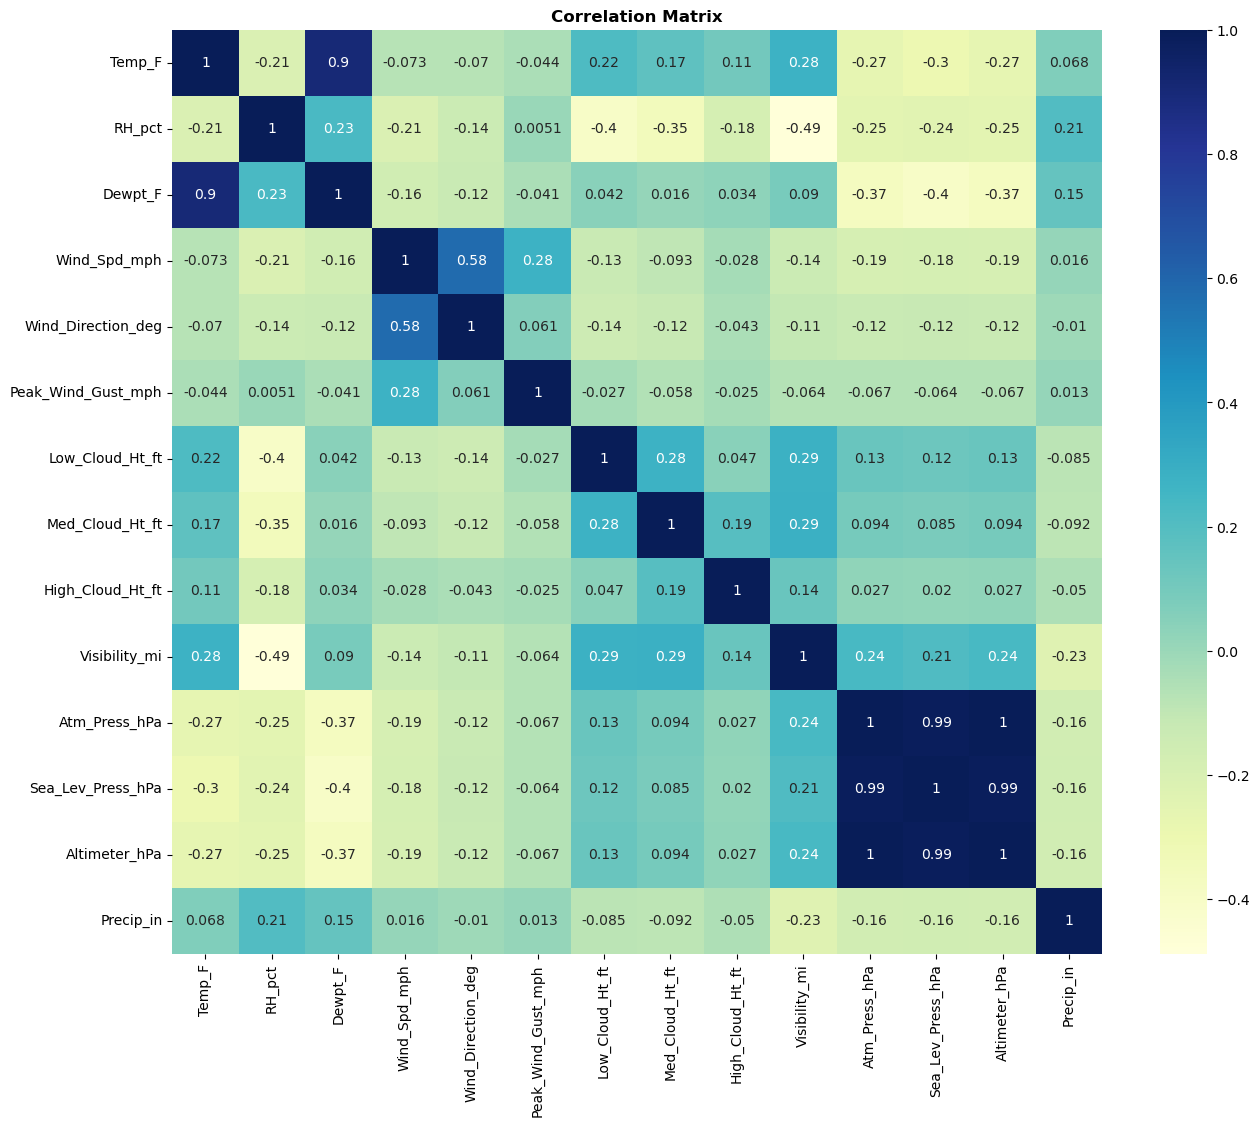

In [38]:
# Correlation 
correlation_matrix = filtered_sub_les.corr(method = 'pearson')
plt.subplots(figsize=(15,12))

# Heatmap
sns.heatmap(correlation_matrix, annot = True, cmap = "YlGnBu")
plt.title("Correlation Matrix", size = 12, weight = 'bold')

**Observations from the above correlation plots:**
- Few features are very heavily correated with each other
- We remove the ones that have shown `positive correlation` greater than 0.6
    - **Temp_F** is highly correlated with **Dewpt_F**
    - **Wind_Spd_mph** is highly correlated with **Peak_Wind_Gust_mph**
- We also note some strong `negative correlation`, but all of them are greater than -0.6, hence we do not drop those features

We can drop the above columns since they imply to the same information, and keeping them as features will increase the model size.

In [39]:
filtered_les = sub_les.drop(['Dewpt_F', 'Peak_Wind_Gust_mph'], axis=1)
filtered_les = filtered_les.reset_index(drop=True)

In [40]:
filtered_les.shape

(15257, 20)

In [41]:
filtered_les.head()

Date_UTC Time_UTC    Date_CST Time_CST  \
0  2006-10-01    14:00  2006-10-01    14:00   
1  2006-10-01    15:00  2006-10-01    15:00   
2  2006-10-01    16:00  2006-10-01    16:00   
3  2006-10-01    17:00  2006-10-01    17:00   
4  2006-10-01    18:00  2006-10-01    18:00   

                       File_name_for_1D_lake  \
0  goes11.2006.10.01.1400.v01.nc-var1-t0.csv   
1  goes11.2006.10.01.1500.v01.nc-var1-t0.csv   
2  goes11.2006.10.01.1600.v01.nc-var1-t0.csv   
3  goes11.2006.10.01.1700.v01.nc-var1-t0.csv   
4  goes11.2006.10.01.1800.v01.nc-var1-t0.csv   

                             File_name_for_2D_lake  \
0  T_goes11.2006.10.01.1400.v01.nc-var1-t0.csv.csv   
1  T_goes11.2006.10.01.1500.v01.nc-var1-t0.csv.csv   
2  T_goes11.2006.10.01.1600.v01.nc-var1-t0.csv.csv   
3  T_goes11.2006.10.01.1700.v01.nc-var1-t0.csv.csv   
4  T_goes11.2006.10.01.1800.v01.nc-var1-t0.csv.csv   

                                        Lake_data_1D  \
0  [0.067499995, 0.07, 0.0625, 0.06, 0.0725, 0.06...   
1  [0.067499995, 0.067499995, 0.06, 0.06, 0.05749...   
2  [0.0725, 0.067499995, 0.07, 0.07, 0.067499995,...   
3  [0.067499995, 0.067499995, 0.067499995, 0.07, ...   
4  [0.085, 0.085, 0.0875, 0.0725, 0.0775, 0.0775,...   

                                        Lake_data_2D  Temp_F  RH_pct  \
0  [array([       nan,        nan,        nan,   ...    60.0    49.0   
1  [array([       nan,        nan,        nan,   ...    60.0    47.0   
2  [array([   nan,    nan,    nan,    nan,    nan...    59.0    55.0   
3  [array([ nan,  nan,  nan,  nan,  nan,  nan,  n...    55.0    71.0   
4  [array([   nan,    nan,    nan,    nan,    nan...    50.0    82.0   

   Wind_Spd_mph  Wind_Direction_deg  Low_Cloud_Ht_ft  Med_Cloud_Ht_ft  \
0          10.0          270.000000           3600.0      7092.717027   
1           3.0          165.463139              0.0      7092.717027   
2           6.0           40.000000              0.0      7092.717027   
3           0.0            0.000000              0.0      7092.717027   
4           0.0            0.000000           8000.0      7092.717027   

   High_Cloud_Ht_ft  Visibility_mi  Atm_Press_hPa  Sea_Lev_Press_hPa  \
0       8467.732321           10.0          994.7             1017.8   
1       8467.732321           10.0          994.7             1017.7   
2       8467.732321           10.0          994.7             1017.8   
3       8467.732321           10.0          994.7             1017.8   
4       8467.732321           10.0          994.7             1017.9   

   Altimeter_hPa  Precip_in  
0         1017.6        0.0  
1         1017.6        0.0  
2         1017.6        0.0  
3         1017.6        0.0  
4         1017.6        0.0

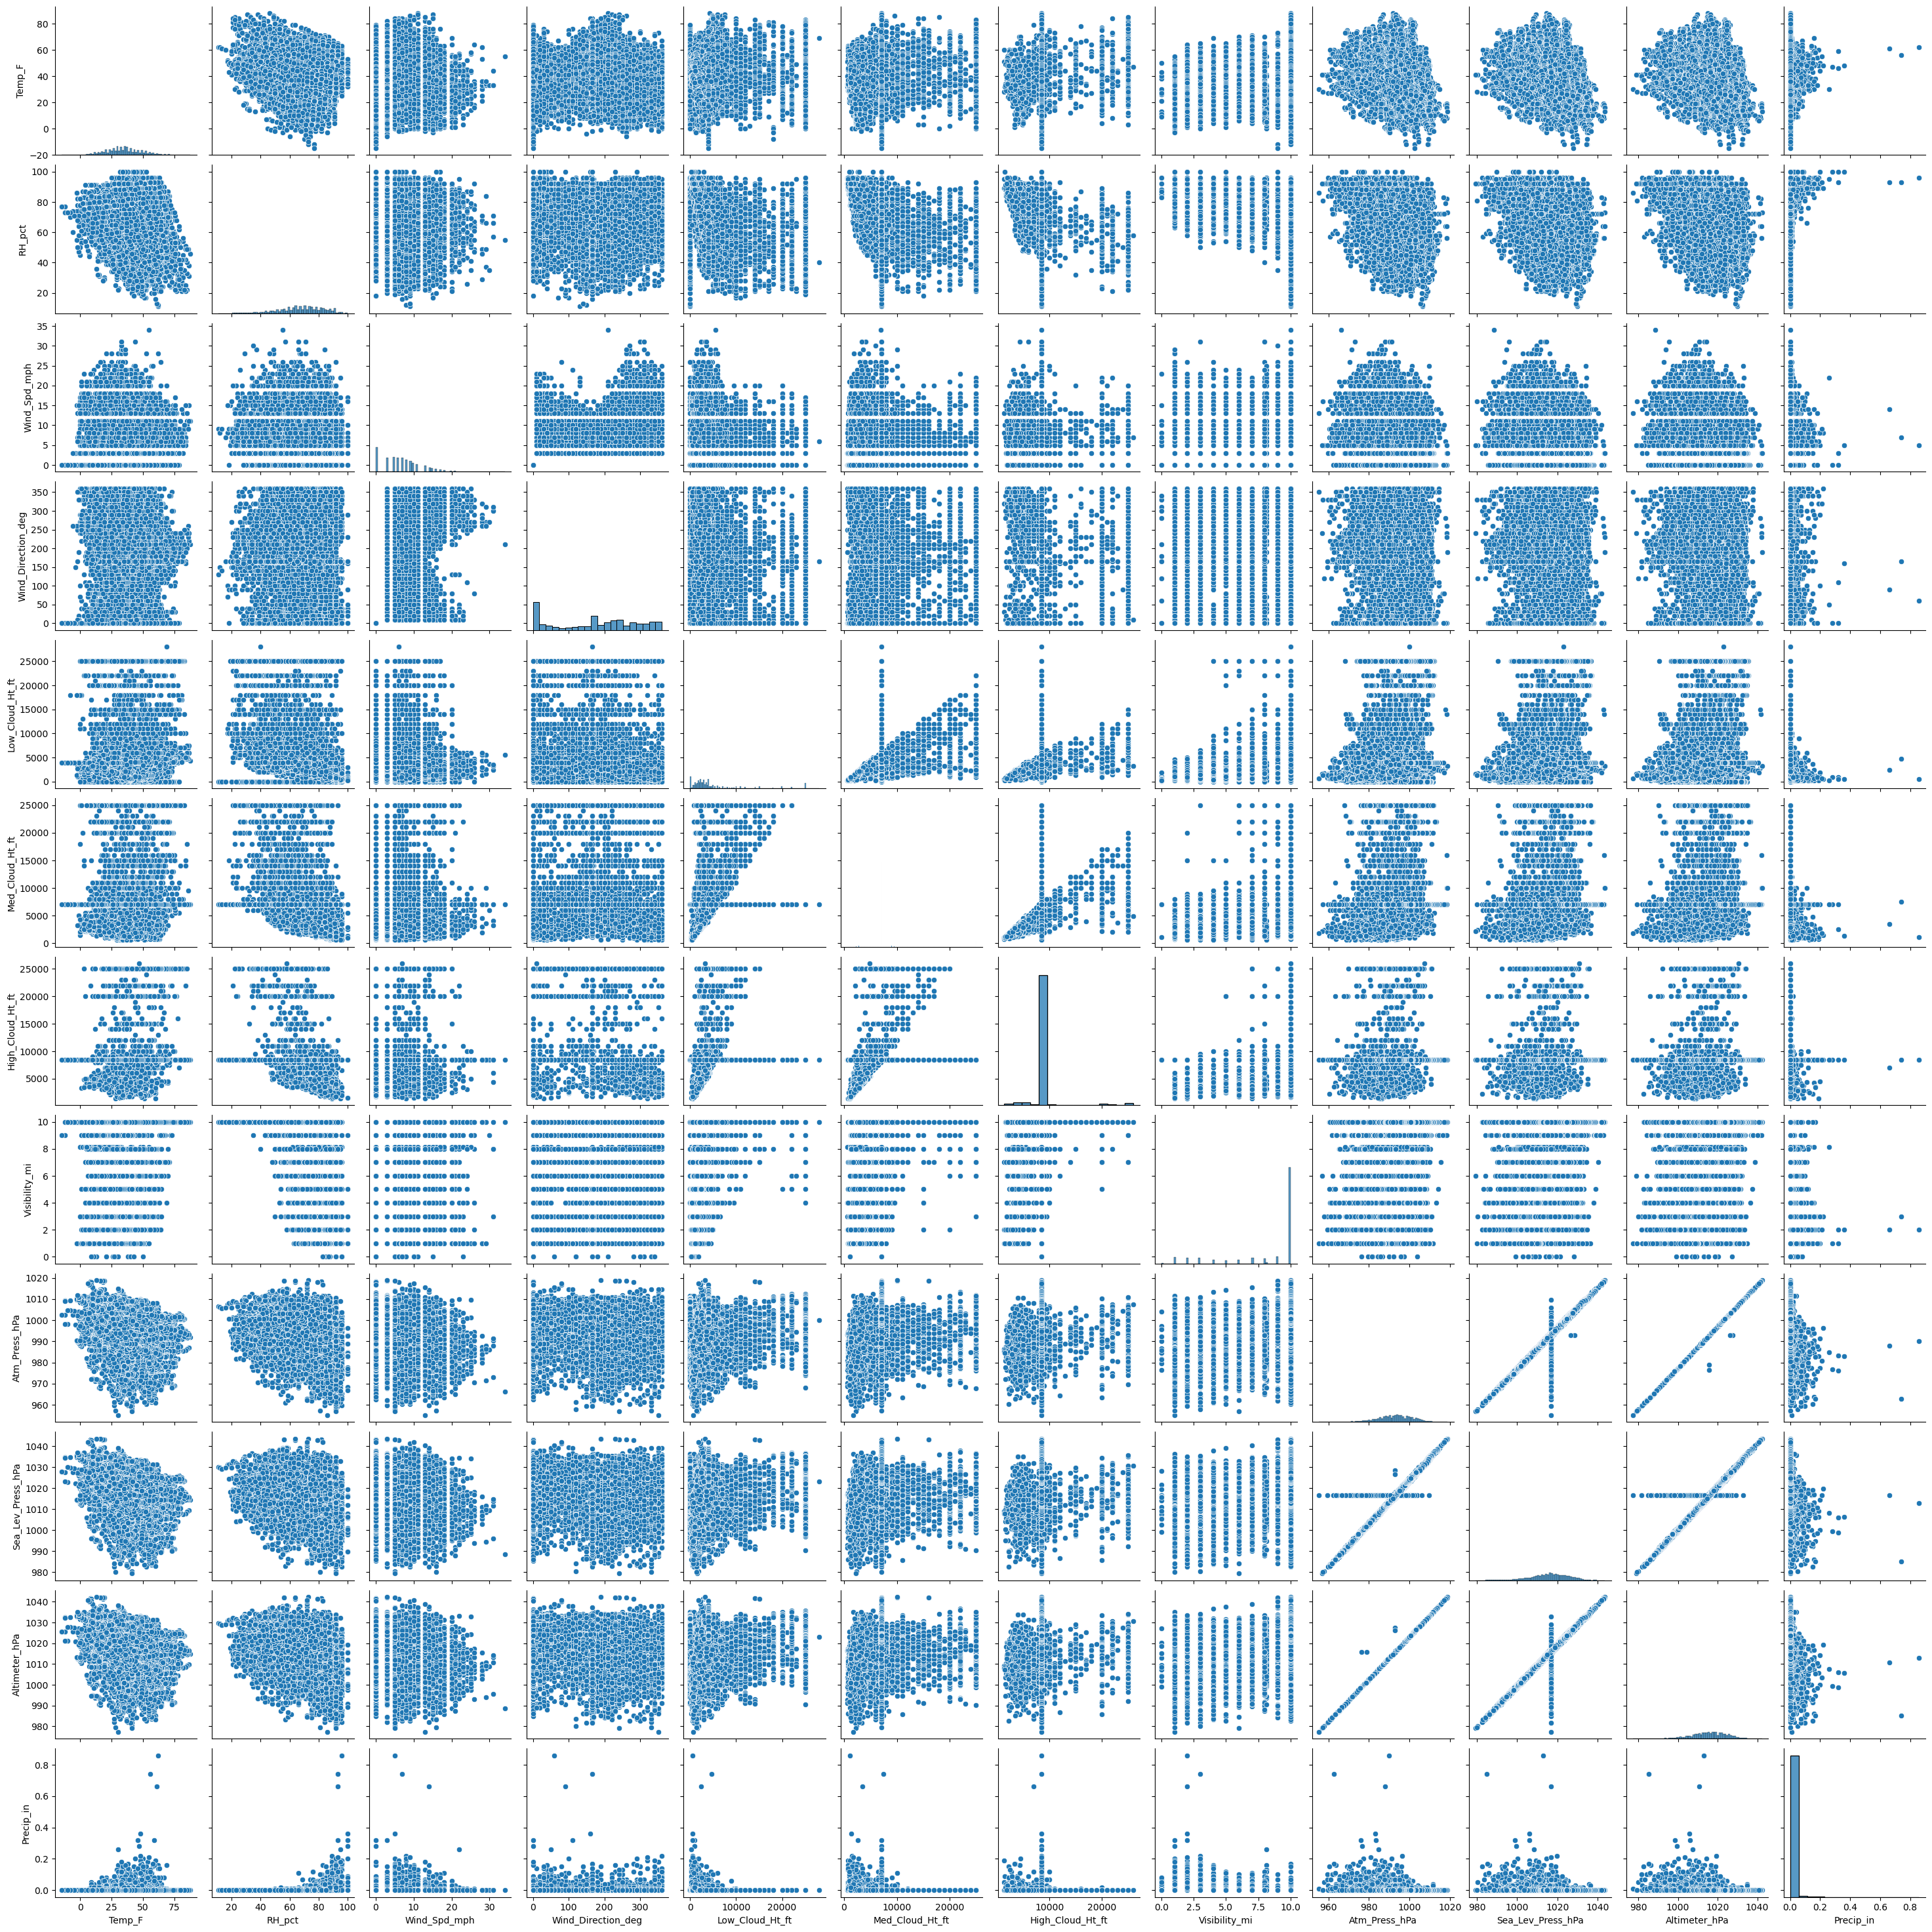

In [42]:
sns.pairplot(filtered_les)

In [43]:
# Exclude "data" and "time" columns
columns_to_exclude = ['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake',
       'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D']
filtered_sub_les = filtered_les.drop(columns=columns_to_exclude, errors='ignore')

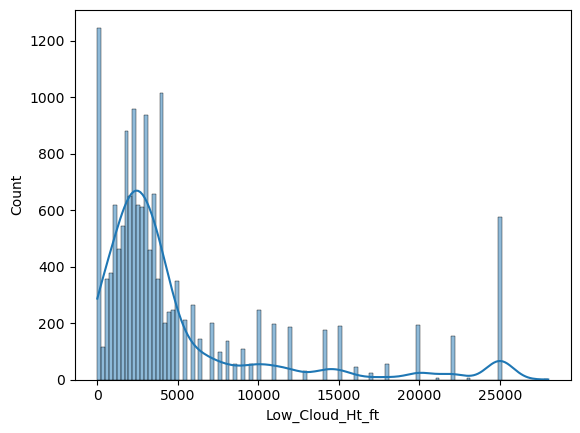

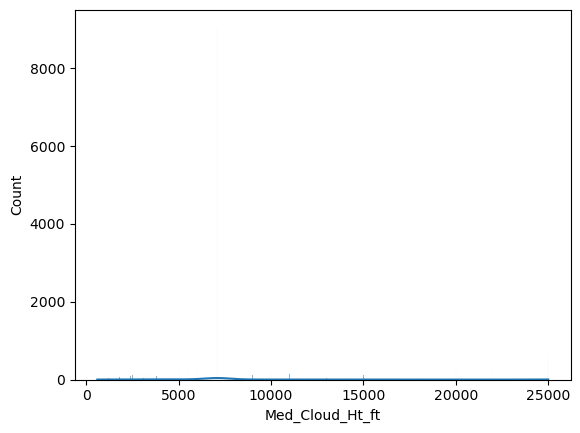

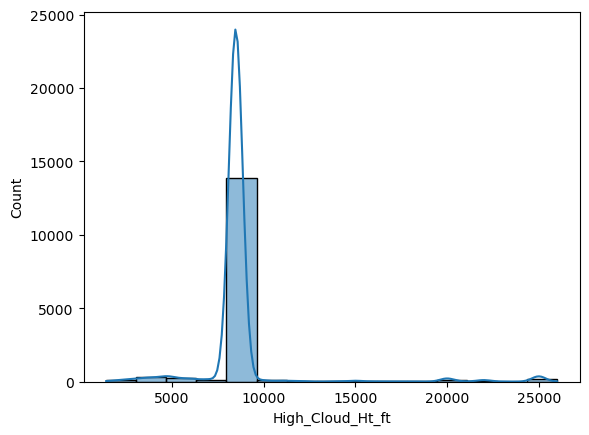

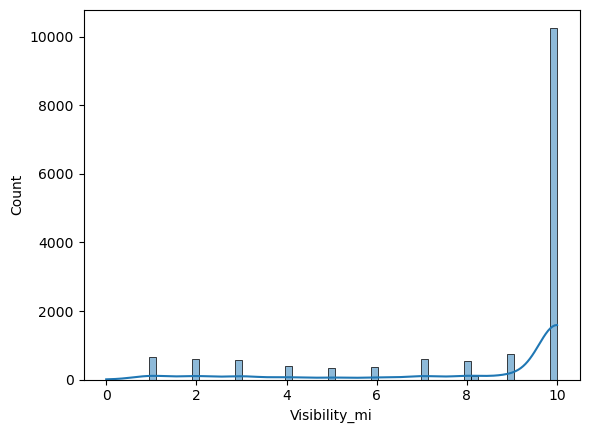

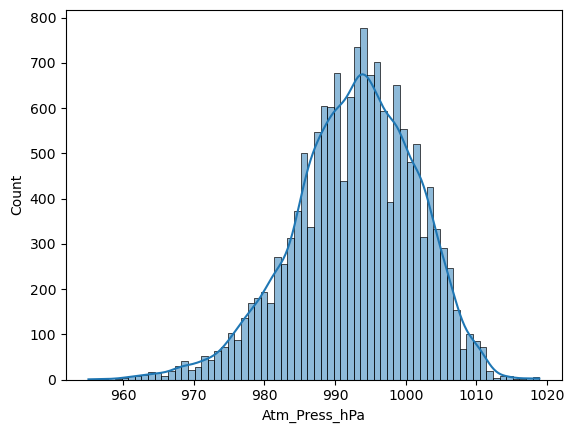

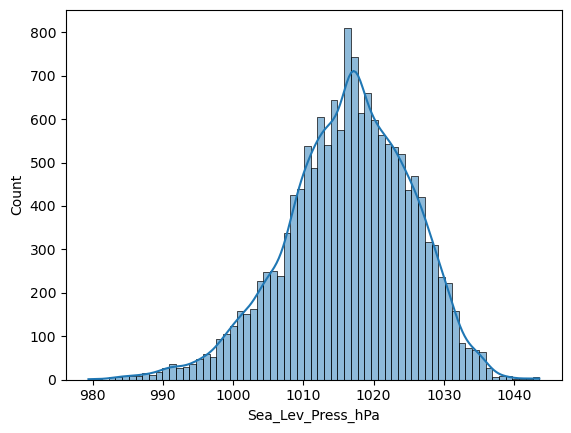

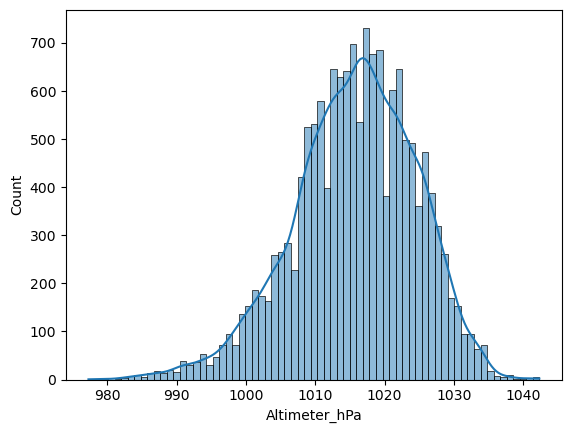

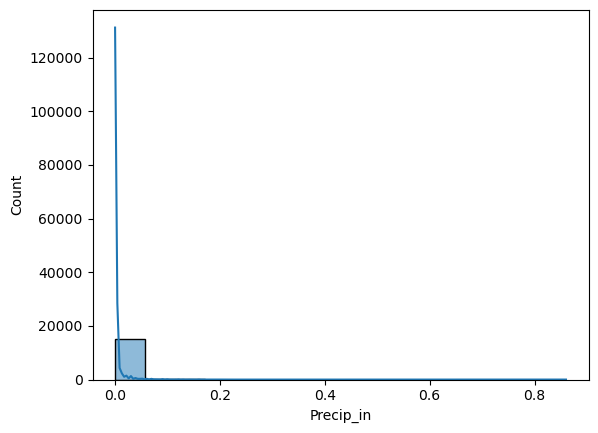

In [44]:
def distPlot(data):
    cols = data.columns[4:]
    for col in cols:
        sns.histplot(data[col], kde=True)
        plt.show()
        
distPlot(filtered_sub_les)

Saving the filtered csv based on correlation found

In [45]:
filtered_les.to_csv('filtered_lake_les_1.csv', index=False)

Saving filtered csv without date and time column

In [46]:
filtered_sub_les.to_csv('filtered_lake_les_withoutDateTime.csv', index=False)

# Understanding Precipitation data

In [47]:
sub_les["Precip_in"].value_counts()

0.00    14125
0.01      509
0.02      195
0.03      142
0.04       69
0.05       48
0.06       31
0.07       31
0.09       19
0.08       16
0.10       14
0.12       10
0.15        6
0.16        6
0.13        6
0.14        6
0.11        5
0.17        3
0.32        2
0.19        2
0.18        2
0.20        2
0.26        1
0.28        1
0.36        1
0.86        1
0.66        1
0.74        1
0.22        1
0.21        1
Name: Precip_in, dtype: int64

<Axes: xlabel='Precip_in', ylabel='Count'>

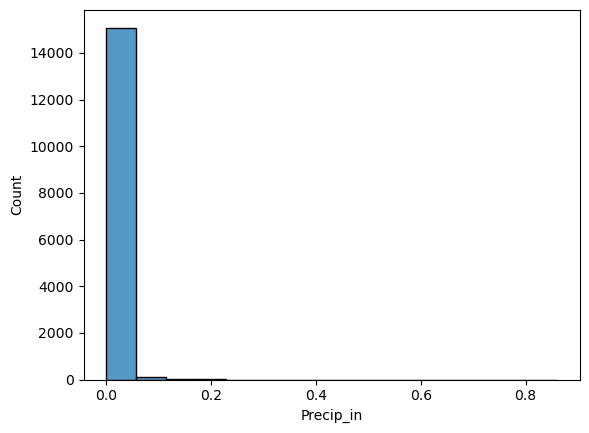

In [48]:
sns.histplot(sub_les["Precip_in"])

In [49]:
# drop(
#     [ 'Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 
#      'Lake_data_1D', 'Lake_data_2D', 'Dewpt_F', 'Peak_Wind_Gust_mph', 'Altimeter_hPa' ], axis=1)

In [50]:
filtered_sub_les.columns

Index(['Temp_F', 'RH_pct', 'Wind_Spd_mph', 'Wind_Direction_deg',
       'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft', 'High_Cloud_Ht_ft',
       'Visibility_mi', 'Atm_Press_hPa', 'Sea_Lev_Press_hPa', 'Altimeter_hPa',
       'Precip_in'],
      dtype='object')

Categorizing the rain into binary data

In [51]:
filtered_sub_les.loc[filtered_sub_les['Precip_in'] > 0, 'LES_Precipitation'] = 1
filtered_sub_les.loc[filtered_sub_les['Precip_in'] <= 0, 'LES_Precipitation'] = 0
filtered_sub_les

Temp_F  RH_pct  Wind_Spd_mph  Wind_Direction_deg  Low_Cloud_Ht_ft  \
0        60.0    49.0          10.0          270.000000           3600.0   
1        60.0    47.0           3.0          165.463139              0.0   
2        59.0    55.0           6.0           40.000000              0.0   
3        55.0    71.0           0.0            0.000000              0.0   
4        50.0    82.0           0.0            0.000000           8000.0   
...       ...     ...           ...                 ...              ...   
15252    39.0    54.0           5.0           20.000000           7000.0   
15253    37.0    61.0           3.0          330.000000           5500.0   
15254    37.0    66.0          11.0          310.000000           3500.0   
15255    36.0    85.0           0.0            0.000000           2100.0   
15256    36.0    85.0           0.0            0.000000           4600.0   

       Med_Cloud_Ht_ft  High_Cloud_Ht_ft  Visibility_mi  Atm_Press_hPa  \
0          7092.717027       8467.732321           10.0          994.7   
1          7092.717027       8467.732321           10.0          994.7   
2          7092.717027       8467.732321           10.0          994.7   
3          7092.717027       8467.732321           10.0          994.7   
4          7092.717027       8467.732321           10.0          994.7   
...                ...               ...            ...            ...   
15252     10000.000000       8467.732321           10.0          989.0   
15253      7000.000000       8467.732321           10.0          989.3   
15254      5500.000000       8467.732321           10.0          990.7   
15255      2900.000000       5000.000000           10.0          991.0   
15256      7092.717027       8467.732321           10.0          991.7   

       Sea_Lev_Press_hPa  Altimeter_hPa  Precip_in  LES_Precipitation  
0                 1017.8         1017.6        0.0                0.0  
1                 1017.7         1017.6        0.0                0.0  
2                 1017.8         1017.6        0.0                0.0  
3                 1017.8         1017.6        0.0                0.0  
4                 1017.9         1017.6        0.0                0.0  
...                  ...            ...        ...                ...  
15252             1012.6         1011.9        0.0                0.0  
15253             1012.8         1012.2        0.0                0.0  
15254             1014.1         1013.5        0.0                0.0  
15255             1014.6         1013.9        0.0                0.0  
15256             1015.0         1014.6        0.0                0.0  

[15257 rows x 13 columns]

In [52]:
filtered_sub_les['LES_Precipitation'].value_counts()

0.0    14125
1.0     1132
Name: LES_Precipitation, dtype: int64

<Axes: xlabel='LES_Precipitation', ylabel='count'>

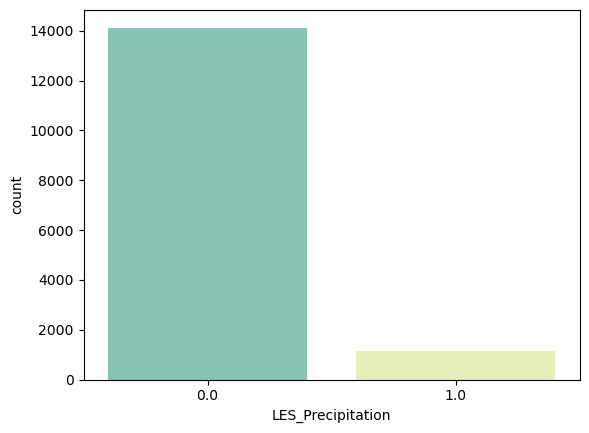

In [53]:
sns.countplot(x = filtered_sub_les['LES_Precipitation'], palette=["#7fcdbb", "#edf8b1"])

# Removing the 255-level padding around Lake Michigan
We need to do this *before* we resize the images to 64 $\times$ 64, otherwise we will get artificial aliasing around the lake MIchigan coastline, which will look like spurious Cloud intensity around the coastline!

We know that image #39 is corrupt: all black. It should give us the shape of Lake Michigan!

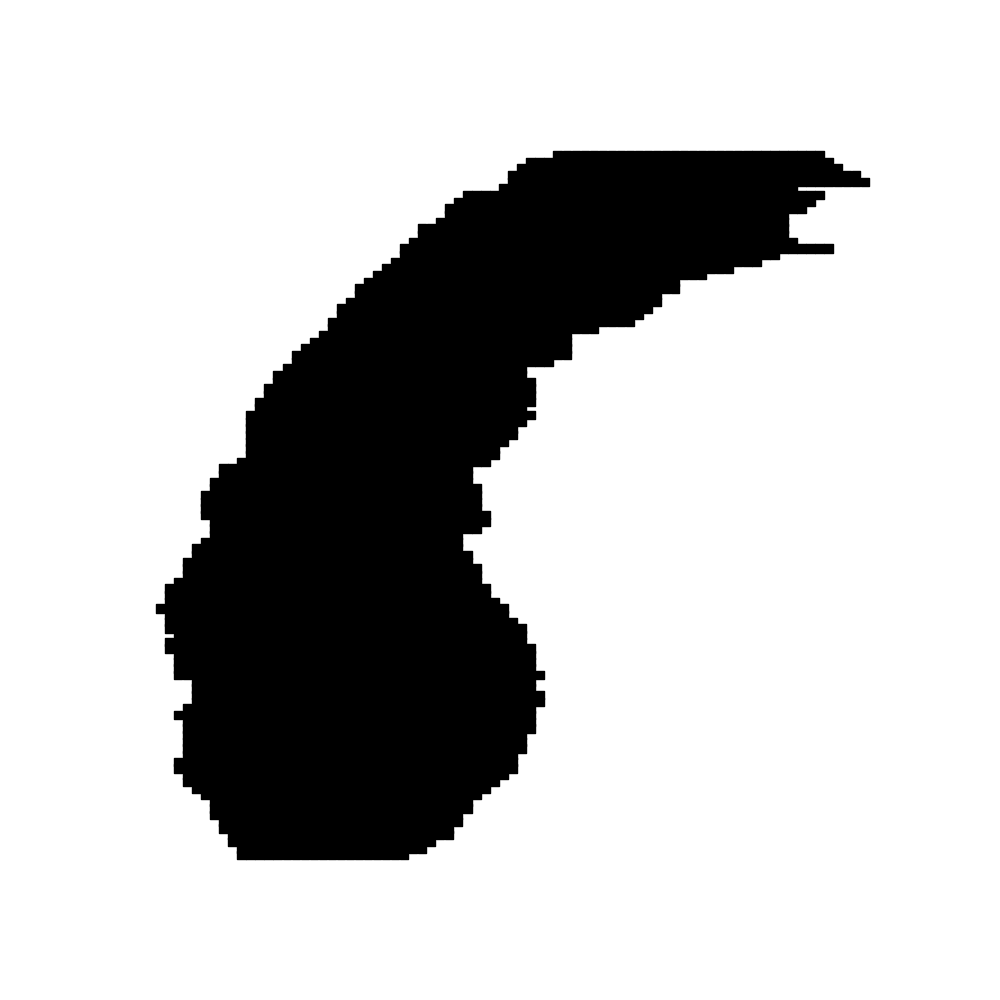

In [56]:
from PIL import Image, ImageOps

img = Image.open(r'/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/tripti/lake_michigan/39.png')
img

In [57]:
#full = np.full(img.size, 255)
img = ImageOps.grayscale(img)
#mask = (full - img).astype(np.uint8)
#mask = (0 < mask).astype(int)
img = np.asarray(img)
mask = (255 != img).astype(int)
np.nonzero(mask)

(array([150, 150, 150, ..., 860, 860, 860]),
 array([553, 554, 555, ..., 406, 407, 408]))

In [ ]:
(mask * 255)[150, 553], (mask * 255)[860, 408]

In [ ]:
plt.imshow(mask * 255, interpolation='none')
plt.show()

In [ ]:
img = Image.open(r'/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/tripti/lake_michigan/6.png')
img = ImageOps.grayscale(img)
img

In [ ]:
newimg = np.asarray(img) * mask # mask with the lake michigan mask to zero out outside region
plt.imshow(newimg, interpolation='none')
plt.show()

In [ ]:
ImageOps.grayscale(Image.fromarray(newimg))

In [ ]:
from PIL import Image, ImageOps
f = '/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/tripti/lake_michigan'
g = '/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/tripti/lake_michigan_64'
for file in tqdm(os.listdir(f)):
    f_img = f + "/" + file
    g_img = g + "/" + file
    img = Image.open(f_img)
    img = ImageOps.grayscale(img)
    newimg = np.asarray(img) * mask # mask with the lake michigan mask to zero out land region
    newimg64 = ImageOps.grayscale(Image.fromarray(newimg)).resize((64,64), Image.ANTIALIAS)
    newimg64.save(g_img)

In [ ]:
import os
from tqdm import tqdm
from PIL import Image, ImageOps
import numpy as np

f_folder = '/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/tripti/lake_michigan'
g_folder = '/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/tripti/lake-michigan-images-64'

for file in tqdm(os.listdir(f_folder)):
    f_img_path = os.path.join(f_folder, file)
    g_img_path = os.path.join(g_folder, file)

    # Check if the file is an image
    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
        try:
            img = Image.open(f_img_path)
            img = ImageOps.grayscale(img)
#             img_array = np.asarray(img, dtype=np.uint8)  # Convert to uint8
#             mask = (255 != img_array).astype(int)
#             np.nonzero(mask)
            new_img_array = img_array * mask

            # Convert new_img_array to uint8 before creating grayscale image
            new_img_array = new_img_array.astype(np.uint8)
            new_img_64 = ImageOps.grayscale(Image.fromarray(new_img_array)).resize((64, 64), Image.ANTIALIAS)
            new_img_64.save(g_img_path)
        except (IOError, OSError, ValueError, Image.DecompressionBombError) as e:
            print(f"Error processing {file}: {e}")
            continue


# Prediciting Cloud patterns 

In [54]:
from tqdm import tqdm
import cv2

images = []
for idx in tqdm(range(15959)):
    image_path = '/Users/cherilyogi/Desktop/Class_Folder/INFO_6106/Final_Project/tripti/lake_michigan_64/' + str(idx) + '.png'
    im = cv2.imread(image_path)

    # Check if the image was successfully read
    if im is not None:
        # Storing 1 channel, since the images are grayscale, and cropping
        images.append(im[8:-8, 8:-8, 0])  # Assuming images are 64x64 pixels
    else:
        print(f"Error reading image at index {idx}. Check if the file exists and is in the correct format.")

100%|██████████| 15959/15959 [00:01<00:00, 10958.55it/s]


In [55]:
len(images)

15959

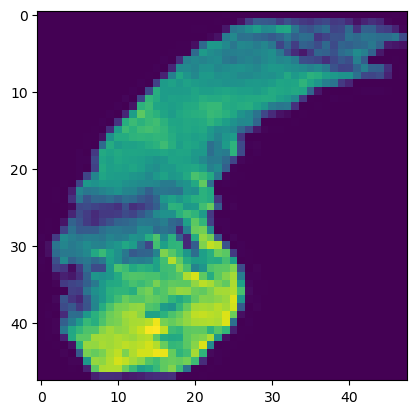

In [56]:
plt.imshow(images[146]) 

# CLoud sequence visualtiation 

Displaying next frames starting at image 9972.


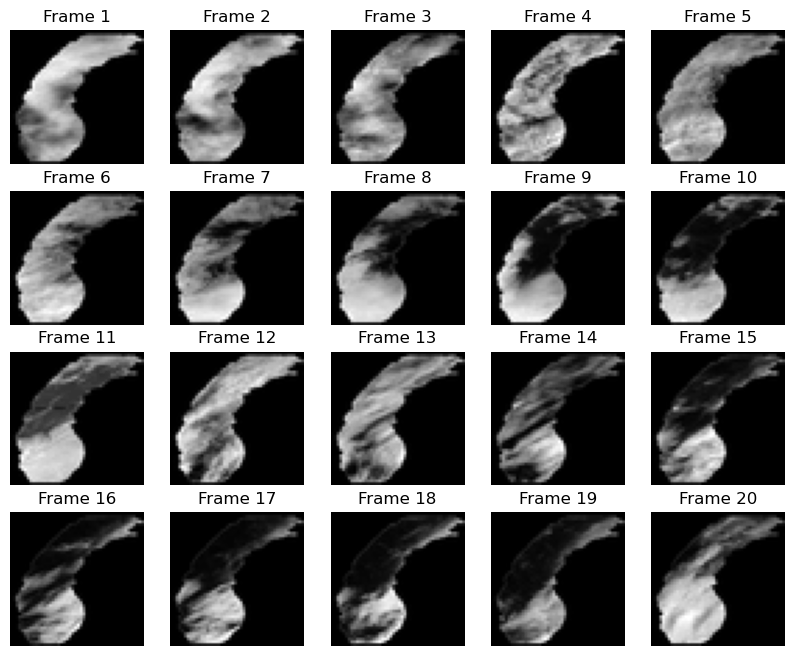

In [57]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(images)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(images[data_choice + idx], cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying next frames starting at image {data_choice}.")
plt.show()

In [58]:
meteo_les = les_full.drop(
    [ 'Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 
     'Lake_data_1D', 'Lake_data_2D', 'Dewpt_F', 'Peak_Wind_Gust_mph', 'Altimeter_hPa' ], axis=1)

In [59]:
import tensorflow as tf 
x3 = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les, None, 24, sequence_stride=24, sampling_rate=1, 
                                                          batch_size=50000)

In [60]:
for batch in x3:
    print(batch.shape)
    print('--')

(1880, 24, 11)
--


In [61]:
meteo_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[0:30000], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=30000)

In [62]:
meteo_train = None
for batch in meteo_train_batched:
    meteo_train = batch
    print(meteo_train.shape)
    print('--')

(1250, 24, 11)
--


In [63]:
meteo_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[:7500], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=7500)

In [64]:
meteo_val = None
for batch in meteo_val_batched:
    meteo_val = batch
    print(meteo_val.shape)
    print('--')

(312, 24, 11)
--


So we have about 3 times more traiing data than test data.

### Cloud imagery training and validation datasets
We can probably use `les_filtered` to gather our imagery data, just liked we did previously. But now our training dataset will consist of 8 hours of imagery and the label will be rain or not *the next day*.

Let's create our imagery training data:

In [65]:
cloud_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:10000], None, 8, sequence_stride=8, 
                                                                           sampling_rate=1, batch_size=10000)

In [66]:
cloud_train = None
for batch in cloud_train_batched:
    cloud_train = batch
    cloud_train = np.expand_dims(cloud_train, axis=-1)
    print(cloud_train.shape)
    cloud_train = cloud_train / 255
    print('--')

(1250, 8, 48, 48, 1)
--


In [67]:
cloud_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:2500], None, 8, sequence_stride=8, 
                                                                         sampling_rate=1, batch_size=2500)

In [68]:
cloud_val = None
for batch in cloud_val_batched:
    cloud_val = batch
    cloud_val = np.expand_dims(cloud_val, axis=-1)
    print(cloud_val.shape)
    cloud_val = cloud_val / 255
    print('--')

(312, 8, 48, 48, 1)
--


In [69]:
meteo_train.shape

TensorShape([1250, 24, 11])

Final rain classification label
Finally, let's create our label:


In [70]:
rain_train = []
for batch in meteo_train_batched:
    for i in range(batch.shape[0]):
        print(batch.shape[0])
        print(batch[i,:,-1].numpy())
        print(i)
        break

1250
[0.   0.   0.   0.   0.02 0.01 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
0


In [71]:
rain_train = []
for batch in meteo_train_batched:
    for i in range(batch.shape[0]):
        rain_train.append(sum(batch[i,:,-1].numpy()))
        
len(rain_train)

1250

In [72]:
print(rain_train)

[0.03, 0.01, 2.02, 0.35, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.5299999999999999, 0.19999999999999998, 0.28, 0.01, 0.04, 0.4200000000000001, 0.15, 0.09000000000000001, 0.0, 0.3400000000000001, 0.4700000000000001, 0.05, 0.03, 0.0, 0.0, 0.24000000000000005, 0.18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.01, 0.21999999999999997, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.13999999999999999, 0.28, 0.06, 0.6200000000000001, 0.01, 0.04, 0.0, 0.01, 0.04, 0.0, 0.0, 0.0, 0.0, 0.15, 0.05, 0.03, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.5700000000000001, 0.13999999999999999, 0.0, 0.02, 0.01, 0.03, 0.02, 0.0, 0.14, 0.03, 0.02, 0.0, 0.0, 0.0, 0.0, 0.05, 0.060000000000000005, 0.0, 0.0, 0.02, 0.02, 0.01, 0.05, 0.21000000000000002, 0.03, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.02, 0.0, 0.0, 0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.02, 0.01, 0.04, 0.0, 0.0, 0.02, 0.08, 0.0, 0.0, 0.1, 0.17, 0.02, 0.01, 0.04, 0.02, 0.0, 0.0, 0.07

In [73]:
rain_train_b = [1 if 0.10 <= r else 0 for r in rain_train]

In [177]:
len(rain_train)


1250

In [74]:
print(rain_train_b)

[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

(array([1047.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         203.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

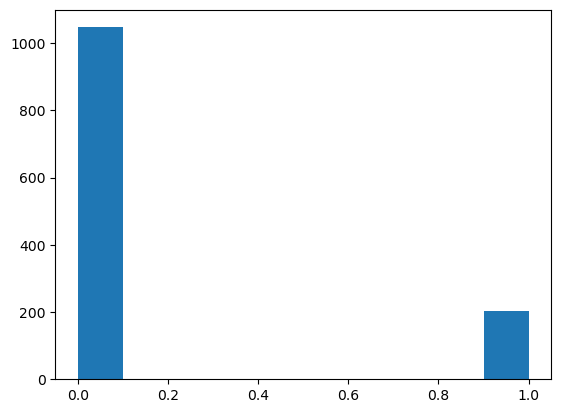

In [75]:
plt.hist(rain_train_b)

In [76]:
rain_train_c = np.array(rain_train_b)
rain_train_c.shape

(1250,)

In [77]:
rain_val = []
for batch in meteo_val_batched:
    for i in range(batch.shape[0]):
        rain_val.append(sum(batch[i,:,-1].numpy()))
        
len(rain_val)

312

In [78]:
rain_val_b = [1 if 0.10 <= r else 0 for r in rain_val]

In [79]:
rain_val_c = np.array(rain_val_b)
rain_val_c.shape

(312,)

# Imagery Network 

In [80]:
# Construct the input layer with no definite frame size (None below could be replaced by 8)
inp = layers.Input(shape=(8, *cloud_train.shape[2:]))
print("layers.Input(shape=", inp.shape)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
print("ConvLSTM2D filters=64, kernel_size=(5, 5)", x.shape)
x = layers.BatchNormalization()(x)
print("BatchNormalization", x.shape)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
print("ConvLSTM2D filters=64, kernel_size=(3, 3)", x.shape)
x = layers.BatchNormalization()(x)
print("BatchNormalization", x.shape)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
print("ConvLSTM2D filters=64, kernel_size=(1, 1)", x.shape)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)
print("Conv3D kernel_size=(3, 3, 3)", x.shape)

layers.Input(shape= (None, 8, 48, 48, 1)
ConvLSTM2D filters=64, kernel_size=(5, 5) (None, 8, 48, 48, 64)
BatchNormalization (None, 8, 48, 48, 64)
ConvLSTM2D filters=64, kernel_size=(3, 3) (None, 8, 48, 48, 64)
BatchNormalization (None, 8, 48, 48, 64)
ConvLSTM2D filters=64, kernel_size=(1, 1) (None, 8, 48, 48, 64)
Conv3D kernel_size=(3, 3, 3) (None, 8, 48, 48, 1)


In [81]:
x.shape

TensorShape([None, 8, 48, 48, 1])

In [82]:
# Flatten the ConvLSTM output
flattened_satellite = Flatten()(x)

In [83]:
flattened_satellite.shape

TensorShape([None, 18432])

In [84]:
inp.shape

TensorShape([None, 8, 48, 48, 1])

In [85]:
# from tensorflow import keras 

# conv_model = keras.models.Model(inp, x)
# # model.compile(
# #     loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.legacy.Adam(),
# # )
# model.summary()

In [86]:
# Define some callbacks to improve training
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_delta=0.005)

In [87]:
cloud_train.shape

(1250, 8, 48, 48, 1)

In [88]:
# cloud_train_dataset = None
# for batch in cloud_train:
#     cloud_train_dataset = np.expand_dims(batch, axis=-1)
# #     print(cloud_train_dataset.shape)
#     cloud_train_dataset = cloud_train_dataset / 255

In [89]:
# def create_shifted_frames(data):
#     x = data[:, 0 : data.shape[1] - 1, :, :]
#     y = data[:, 1 : data.shape[1], :, :]
#     return x, y
 
# # Apply the processing function to the datasets.
# x_train, y_train = create_shifted_frames(cloud_train)
# x_val, y_val = create_shifted_frames(cloud_val)
 
# # Inspect the dataset.
# print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
# print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

In [90]:
# # Define modifiable training hyperparameters
# epochs = 40
# batch_size = 5
 
# from datetime import datetime
# now = datetime.now()
# current_time = now.strftime("%H:%M:%S")
# print("Started training at", current_time)
 
# # Fit the model to the training data
# model.fit(
#     x_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(x_val, y_val),
#     callbacks=[early_stopping, reduce_lr],
# )
 
# now = datetime.now()
# current_time = now.strftime("%H:%M:%S")
# print("Finished training at", current_time)

In [91]:
meteo_les.shape

(45134, 11)

LSTM

In [92]:
meteo_train.shape[2]

11

In [93]:
type(meteo_train_batched)

tensorflow.python.data.ops.batch_op._BatchDataset

In [94]:
# lstm_model = Sequential() # LSTM layer with Dropout
# lstm_model.add(LSTM(units = 50, return_sequences=True, input_shape=(meteo_train.shape[1], meteo_train.shape[2])))
# lstm_model.add(Dropout(0.2))  # Adjust dropout rate based on your needs# Add a Dense layer with Dropout after LSTM (optional)
# lstm_model.add(Dense(units=32, activation='relu')) 
# lstm_model.add(Dropout(0.2))

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L2

# Create a Sequential model
lstm_model = Sequential()

# LSTM layer with L2 regularization and dropout
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(meteo_train.shape[1], meteo_train.shape[2]), kernel_regularizer=L2(0.01)))
lstm_model.add(Dropout(0.3))

# Batch Normalization
lstm_model.add(BatchNormalization())

# Dense layer with dropout
lstm_model.add(Dense(units=64, activation='relu', kernel_regularizer=L2(0.01)))
lstm_model.add(Dropout(0.3))

# Output layer for binary classification
lstm_model.add(Dense(units=1, activation='sigmoid'))


In [96]:
# from keras.layers import BatchNormalization

# # Create a Sequential model
# lstm_model = Sequential()

# # LSTM layer with Dropout
# lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(meteo_train.shape[1], meteo_train.shape[2])))
# lstm_model.add(Dropout(0.3))  # Adjust dropout rate

# # Add Batch Normalization
# lstm_model.add(BatchNormalization())

# # Add another LSTM layer with Dropout
# lstm_model.add(LSTM(units=50, return_sequences=True))
# lstm_model.add(Dropout(0.2))

# # Add a Dense layer with Dropout
# lstm_model.add(Dense(units=32, activation='relu'))
# lstm_model.add(Dropout(0.2))

# # Output layer
# lstm_model.add(Dense(units=1, activation='sigmoid'))

In [131]:
lstm_model.input.shape

TensorShape([None, 24, 11])

In [97]:
flattened_meteo = Flatten()(lstm_model.output)

In [98]:
flattened_meteo.shape

TensorShape([None, 24])

concatenate

In [99]:
from sklearn.utils.class_weight import compute_class_weight

In [100]:
# class_weights = compute_class_weight('balanced', classes = [0,1], y=rain_train_c)

In [101]:
# class_weights = compute_class_weight('balanced', classes=[0, 1], y=rain_train_c)
# class_weights = {0: class_weights[0] / sum(class_weights), 1: class_weights[1] / sum(class_weights)}
# class_weights

In [102]:
# class_weights = compute_class_weight('balanced', classes=[0, 1], y=rain_train_b)
# class_weights = {0: 1 , 1: 6}

In [103]:
from tensorflow.keras.layers import Concatenate, Dense, Dropout

# Assuming 'flattened_meteo' and 'flattened_satellite' are the output layers of your two models
concatenated = Concatenate()([flattened_meteo, flattened_satellite])

# Add additional layers after concatenation
dense_layer1 = Dense(units=64, activation='relu')(concatenated)
dropout_layer1 = Dropout(0.3)(dense_layer1)

dense_layer2 = Dense(units=32, activation='relu')(dropout_layer1)
dropout_layer2 = Dropout(0.3)(dense_layer2)

# Output layer for binary classification
output_layer = Dense(units=1, activation='sigmoid')(dropout_layer2)


In [104]:
# Create the combined model
combined_model = Model(inputs=[lstm_model.input, inp], outputs=output_layer)

In [109]:
# # Concatenate the outputs
# concatenated = layers.Concatenate()([flattened_meteo, flattened_satellite])

# # Add a Dense layer for the final prediction
# output_layer = layers.Dense(units=1, activation='sigmoid')(concatenated)

In [110]:
# # Create the combined model
# combined_model = Model(inputs=[lstm_model.input, inp], outputs=output_layer)

In [111]:
# class_weights = {0: class_weights[0], 1: class_weights[1]}
# class_weights

In [112]:
# Initialize the EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True)

In [105]:
optimizer = tf.keras.optimizers.legacy.Adam(clipvalue=0.5)

In [114]:
# pip install tensorflow-addons

In [115]:
# from tensorflow_addons.metrics import F1Score
# f1_score_metric = F1Score(num_classes=2, threshold=0.5)

In [106]:
# Compile the model
combined_model.compile(
#     optimizer= 'adam',
                       optimizer=optimizer,
                       loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision()])
# Print the model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_input (InputLayer)     [(None, 24, 11)]             0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 8, 48, 48, 1)]       0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 24, 100)              44800     ['lstm_input[0][0]']          
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    (None, 8, 48, 48, 64)        416256    ['input_1[0][0]']             
                                                                                              

Class weights with 1:6 ratio
Logic: 
Training data set has 190 - 1's, 1060- 0's ; Validation data set has 51 -1's and 261 - 0' 
Almost there is a ratio of 1:5.57

In [155]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=rain_train_b)
class_weights = {0: 1 , 1: 6}

In [119]:
# Train the model using your data
# meteo_train is the input for the LSTM model, and convlstm2d_input is the input for the ConvLSTM2D model
combined_model.fit([meteo_train, cloud_train], rain_train_c, epochs=10, batch_size=32, 
                   class_weight=class_weights,
#                    callbacks=[early_stopping],
#                   validation_data=([meteo_val, cloud_val], rain_val_c)
                  )

Epoch 1/10
40/40 [==============================] - 336s 8s/step - loss: 2.2692 - accuracy: 0.4040 - precision: 0.1638
Epoch 2/10
40/40 [==============================] - 335s 8s/step - loss: 1.5935 - accuracy: 0.2768 - precision: 0.1587
Epoch 3/10
40/40 [==============================] - 336s 8s/step - loss: 1.4090 - accuracy: 0.1936 - precision: 0.1626
Epoch 4/10
40/40 [==============================] - 336s 8s/step - loss: 1.3218 - accuracy: 0.1736 - precision: 0.1604
Epoch 5/10
40/40 [==============================] - 358s 9s/step - loss: 1.2840 - accuracy: 0.1648 - precision: 0.1617
Epoch 6/10
40/40 [==============================] - 346s 9s/step - loss: 1.2641 - accuracy: 0.1632 - precision: 0.1625
Epoch 7/10
40/40 [==============================] - 343s 9s/step - loss: 1.2558 - accuracy: 0.1640 - precision: 0.1627
Epoch 8/10
40/40 [==============================] - 347s 9s/step - loss: 1.2476 - accuracy: 0.1624 - precision: 0.1608
Epoch 9/10
40/40 [==============================

Predicting for validation

In [120]:
predictions = combined_model.predict([meteo_val, cloud_val])

10/10 [==============================] - 22s 2s/step


In [121]:
binary = (predictions > 0.5).astype(int)

In [123]:
from sklearn.metrics import classification_report
thresholds = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6]

for threshold in thresholds:
    y_pred_adjusted = (predictions >= threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(classification_report(rain_val_c, y_pred_adjusted))


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       259
           1       0.17      1.00      0.29        53

    accuracy                           0.17       312
   macro avg       0.08      0.50      0.15       312
weighted avg       0.03      0.17      0.05       312

Threshold: 0.4
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       259
           1       0.17      1.00      0.29        53

    accuracy                           0.17       312
   macro avg       0.08      0.50      0.15       312
weighted avg       0.03      0.17      0.05       312

Threshold: 0.45
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       259
           1       0.17      1.00      0.29        53

    accuracy                           0.17       312
   macro avg       0.08      0.50      0.15       312
weighted avg       0.03     

/Users/cherilyogi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cherilyogi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cherilyogi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cheril

In [124]:
unique_values = np.unique(binary)
unique_values

array([1])

In [125]:
np.unique(rain_val_c)

array([0, 1])

In [126]:
from sklearn.metrics import confusion_matrix

# Assuming 'y_true' is the true class labels and 'y_pred' is the predicted class labels
conf_matrix = confusion_matrix(rain_val_c, binary)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  0 259]
 [  0  53]]


In [127]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for class 1
class_1_accuracy = accuracy_score(rain_val_c, binary)
# print(f'Accuracy for Class 1: {class_1_accuracy * 100:.2f}%')

In [128]:
# Calculate accuracy for class 1 only
class_1_mask = (rain_val_c == 1)
class_1_accuracy = accuracy_score(rain_val_c[class_1_mask], binary[class_1_mask])
print(f'Accuracy for Class 1: {class_1_accuracy * 100:.2f}%')

Accuracy for Class 1: 100.00%


With 1:3

In [156]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=rain_train_b)
class_weights = {0: 1 , 1: 3}

In [158]:
# Train the model using your data
# meteo_train is the input for the LSTM model, and convlstm2d_input is the input for the ConvLSTM2D model
combined_model.fit([meteo_train, cloud_train], rain_train_c, epochs=10, batch_size=32, 
                   class_weight=class_weights,
#                    callbacks=[early_stopping],
#                   validation_data=([meteo_val, cloud_val], rain_val_c)
                  )

Epoch 1/10
40/40 [==============================] - 407s 10s/step - loss: 0.9273 - accuracy: 0.5024 - precision: 0.1933
Epoch 2/10
40/40 [==============================] - 16820s 416s/step - loss: 0.9027 - accuracy: 0.8216 - precision: 0.3611
Epoch 3/10
40/40 [==============================] - 18877s 436s/step - loss: 0.8838 - accuracy: 0.8392 - precision: 0.6667
Epoch 4/10
40/40 [==============================] - 376s 9s/step - loss: 0.8796 - accuracy: 0.8416 - precision: 0.7778
Epoch 5/10
40/40 [==============================] - 371s 9s/step - loss: 0.8682 - accuracy: 0.8392 - precision: 0.6000
Epoch 6/10
40/40 [==============================] - 375s 9s/step - loss: 0.8741 - accuracy: 0.8216 - precision: 0.2500
Epoch 7/10
40/40 [==============================] - 369s 9s/step - loss: 0.8592 - accuracy: 0.8352 - precision: 0.4211
Epoch 8/10
40/40 [==============================] - 364s 9s/step - loss: 0.8534 - accuracy: 0.8416 - precision: 0.6923
Epoch 9/10
40/40 [=====================

Predicting for validation

In [165]:
predictions = combined_model.predict([meteo_val, cloud_val])
binary = (predictions > 0.5).astype(int)
unique_values, count = np.unique(binary, return_counts = True)
unique_values, count

10/10 [==============================] - 24s 2s/step


(array([0, 1]), array([306,   6]))

In [160]:
from sklearn.metrics import confusion_matrix

# Assuming 'y_true' is the true class labels and 'y_pred' is the predicted class labels
conf_matrix = confusion_matrix(rain_val_c, binary)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[257   2]
 [ 49   4]]


In [161]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for class 1
class_1_accuracy = accuracy_score(rain_val_c, binary)
# print(f'Accuracy for Class 1: {class_1_accuracy * 100:.2f}%')

In [163]:
# Calculate accuracy for class 1 only
class_1_mask = (rain_val_c == 1)
class_1_accuracy = accuracy_score(rain_val_c[class_1_mask], binary[class_1_mask])
print(f'Accuracy for Class 1: {class_1_accuracy * 100:.2f}%')

Accuracy for Class 1: 7.55%


1:4

In [107]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=rain_train_b)
class_weights = {0: 1 , 1: 4}

In [108]:
# Train the model using your data
# meteo_train is the input for the LSTM model, and convlstm2d_input is the input for the ConvLSTM2D model
combined_model.fit([meteo_train, cloud_train], rain_train_c, epochs=10, batch_size=32, 
                   class_weight=class_weights,
#                    callbacks=[early_stopping],
#                   validation_data=([meteo_val, cloud_val], rain_val_c)
                  )

Epoch 1/10
40/40 [==============================] - 394s 10s/step - loss: 1.9042 - accuracy: 0.7448 - precision: 0.1420
Epoch 2/10
40/40 [==============================] - 361s 9s/step - loss: 1.3620 - accuracy: 0.8208 - precision: 0.1613
Epoch 3/10
40/40 [==============================] - 359s 9s/step - loss: 1.1718 - accuracy: 0.8344 - precision: 0.1667
Epoch 4/10
40/40 [==============================] - 361s 9s/step - loss: 1.0871 - accuracy: 0.8360 - precision: 0.0000e+00
Epoch 5/10
40/40 [==============================] - 366s 9s/step - loss: 1.0365 - accuracy: 0.8368 - precision: 0.0000e+00
Epoch 6/10
40/40 [==============================] - 378s 9s/step - loss: 1.0105 - accuracy: 0.8336 - precision: 0.3333
Epoch 7/10
40/40 [==============================] - 367s 9s/step - loss: 1.0127 - accuracy: 0.8344 - precision: 0.3571
Epoch 8/10
40/40 [==============================] - 365s 9s/step - loss: 1.0115 - accuracy: 0.8248 - precision: 0.2895
Epoch 9/10
40/40 [=====================

Predicting for validation for 1:4

In [109]:
predictions = combined_model.predict([meteo_val, cloud_val])
binary = (predictions > 0.5).astype(int)
unique_values = np.unique(binary)
unique_values

10/10 [==============================] - 23s 2s/step


array([0])

In [110]:
from sklearn.metrics import confusion_matrix

# Assuming 'y_true' is the true class labels and 'y_pred' is the predicted class labels
conf_matrix = confusion_matrix(rain_val_c, binary)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[259   0]
 [ 53   0]]


In [111]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for class 1
class_1_accuracy = accuracy_score(rain_val_c, binary)
# print(f'Accuracy for Class 1: {class_1_accuracy * 100:.2f}%')

In [113]:
# Calculate accuracy for class 1 only
class_1_mask = (rain_val_c == 1)
class_1_accuracy = accuracy_score(rain_val_c[class_1_mask], binary[class_1_mask])
print(f'Accuracy for Class 1: {class_1_accuracy * 100:.2f}%')

Accuracy for Class 1: 0.00%


1:5

In [114]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=rain_train_b)
class_weights = {0: 1 , 1: 5}

In [115]:
# Train the model using your data
# meteo_train is the input for the LSTM model, and convlstm2d_input is the input for the ConvLSTM2D model
combined_model.fit([meteo_train, cloud_train], rain_train_c, epochs=10, batch_size=32, 
                   class_weight=class_weights,
#                    callbacks=[early_stopping],
#                   validation_data=([meteo_val, cloud_val], rain_val_c)
                  )

Epoch 1/10
40/40 [==============================] - 335s 8s/step - loss: 1.1085 - accuracy: 0.8008 - precision: 0.3750
Epoch 2/10
40/40 [==============================] - 335s 8s/step - loss: 1.0900 - accuracy: 0.7216 - precision: 0.2958
Epoch 3/10
40/40 [==============================] - 337s 8s/step - loss: 1.0935 - accuracy: 0.7440 - precision: 0.3155
Epoch 4/10
40/40 [==============================] - 348s 9s/step - loss: 1.0781 - accuracy: 0.7512 - precision: 0.3373
Epoch 5/10
40/40 [==============================] - 370s 9s/step - loss: 1.0942 - accuracy: 0.6896 - precision: 0.2727
Epoch 6/10
40/40 [==============================] - 358s 9s/step - loss: 1.0956 - accuracy: 0.6520 - precision: 0.2500
Epoch 7/10
40/40 [==============================] - 356s 9s/step - loss: 1.1016 - accuracy: 0.6528 - precision: 0.2473
Epoch 8/10
40/40 [==============================] - 362s 9s/step - loss: 1.1208 - accuracy: 0.6200 - precision: 0.2213
Epoch 9/10
40/40 [==============================

In [122]:
predictions = combined_model.predict([meteo_val, cloud_val])
binary = (predictions > 0.5).astype(int)
unique_values, c = np.unique(binary, return_counts = True)
unique_values, c

10/10 [==============================] - 23s 2s/step


(array([0, 1]), array([ 72, 240]))

In [123]:
unique, count = np.unique(rain_val_c, return_counts = True)
unique, count

(array([0, 1]), array([259,  53]))

In [117]:
from sklearn.metrics import confusion_matrix

# Assuming 'y_true' is the true class labels and 'y_pred' is the predicted class labels
conf_matrix = confusion_matrix(rain_val_c, binary)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 66 193]
 [  6  47]]


In [118]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for class 1
class_1_accuracy = accuracy_score(rain_val_c, binary)
# print(f'Accuracy for Class 1: {class_1_accuracy * 100:.2f}%')

In [120]:
# Calculate accuracy for class 1 only
class_1_mask = (rain_val_c == 1)
class_1_accuracy = accuracy_score(rain_val_c[class_1_mask], binary[class_1_mask])
print(f'Accuracy for Class 1: {class_1_accuracy * 100:.2f}%')

Accuracy for Class 1: 88.68%


# further no, low,medium and high rain

In [161]:
meteo_train_last_col = np.array([batch[:, -1] for batch in meteo_train])
np.unique(meteo_train_last_col), type(meteo_train_last_col)

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.22,
        0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.45, 0.61, 0.66, 0.74, 0.86,
        1.4 ]),
 numpy.ndarray)

In [162]:
len(rain_train)

1250

For train data

In [231]:
# Define thresholds for rain intensity levels
low_threshold = 0.10
medium_threshold = 0.25
high_threshold = 0.50
 
# Create a rain intensity target variable
rain_intensity_train = []
for r in rain_train:
    if low_threshold < r <= medium_threshold:
        rain_intensity_train.append("low")
    elif medium_threshold < r <= high_threshold:
        rain_intensity_train.append("medium")
    elif r >= high_threshold:
        rain_intensity_train.append("high")
    elif r<= low_threshold:
        rain_intensity_train.append("no")
# Convert rain intensity labels to numerical values
rain_intensity_mapping = {"no":0, "low": 1, "medium": 2, "high": 3}
rain_intensity_train_numeric = [rain_intensity_mapping[label] for label in rain_intensity_train]
 
# Now rain_intensity_train_numeric can be used as your target variable for rain intensity

In [232]:
u,c = np.unique(rain_intensity_train_numeric, return_counts = True)
u,c

(array([0, 1, 2, 3]), array([1055,  120,   52,   23]))

In [182]:
1055+120+52+23

1250

In [183]:
len(rain_intensity_train_numeric)

1250

For validation data

In [167]:
# Define thresholds for rain intensity levels
low_threshold = 0.10
medium_threshold = 0.25
high_threshold = 0.50
 
# Create a rain intensity target variable
rain_intensity_val = []
for r in rain_val:
    if low_threshold < r <= medium_threshold:
        rain_intensity_val.append("low")
    elif medium_threshold < r <= high_threshold:
        rain_intensity_val.append("medium")
    elif r >= high_threshold:
        rain_intensity_val.append("high")

# Convert rain intensity labels to numerical values
rain_intensity_mapping = {"low": 1, "medium": 2, "high": 3}
rain_intensity_val_numeric = [rain_intensity_mapping[label] for label in rain_intensity_val]
 
# Now rain_intensity_train_numeric can be used as your target variable for rain intensity

In [168]:
u_val,c_val = np.unique(rain_intensity_val_numeric, return_counts = True)
u_val,c_val

(array([1, 2, 3]), array([29, 17,  5]))

In [169]:
# Assuming rain_intensity_train is your target variable for rain intensity (low, medium, high)
# Convert it to one-hot encoding
rain_intensity_train_one_hot = tf.keras.utils.to_categorical(rain_intensity_train_numeric, num_classes=4)

In [170]:
rain_intensity_train_one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],


In [ ]:
# Define the rain intensity model
rain_intensity_model = tf.keras.Sequential()
# Add layers as needed for predicting rain intensity
# Modify the output layer to have 3 units for low, medium, high

In [ ]:
# Compile the rain intensity model
rain_intensity_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
# Print the model summary
rain_intensity_model.summary()

In [ ]:
# Train the rain intensity model
rain_intensity_model.fit([meteo_rain, cloud_rain], rain_intensity_train_one_hot, epochs=10, batch_size=32)

# Further categorisation


In [380]:
tf.keras.backend.clear_session()

In [381]:
filtered_lstm_input.shape


TensorShape([823, 24, 11])

In [382]:
# Stage 2: Precipitation Intensity Prediction (Only for samples where precipitation occurs)
# Filter samples with precipitation for intensity prediction
precipitation_samples = (combined_model.predict([meteo_train, cloud_train]) > 0.5).astype(int)

precipitation_samples = precipitation_samples.flatten()

40/40 [==============================] - 102s 3s/step


In [383]:
u,c = np.unique(precipitation_samples_1, return_counts = True)
u,c

(array([False,  True]), array([427, 823]))

In [384]:
# Convert rain_intensity_train_numeric to a NumPy array
rain_intensity_train_numeric = np.array(rain_intensity_train_numeric)

# Use only samples where precipitation occurs for intensity prediction
filtered_conv_lstm_input = cloud_train[precipitation_samples==1]
filtered_lstm_input = meteo_train[precipitation_samples==1]
filtered_rain_train = rain_intensity_train_numeric[precipitation_samples==1]

In [385]:
rain_variable = tf.constant(filtered_rain_train)

In [386]:
lstm_step2 = tf.boolean_mask(filtered_lstm_input, tf.not_equal(rain_variable, 0), axis = 0)

In [387]:
lstm_step2.shape

TensorShape([159, 24, 11])

In [388]:
type(lstm_step2)

tensorflow.python.framework.ops.EagerTensor

In [389]:
conv_step2 = tf.boolean_mask(filtered_conv_lstm_input, tf.not_equal(rain_variable, 0), axis = 0)

In [390]:
conv_step2.shape

TensorShape([159, 8, 48, 48, 1])

In [391]:
type(conv_step2)

tensorflow.python.framework.ops.EagerTensor

In [392]:
filtered_rain_train = filtered_rain_train[filtered_rain_train !=0 ]

In [393]:
len(filtered_rain_train)

159

In [394]:
np.unique(filtered_rain_train) 

array([1, 2, 3])

In [395]:
# Construct the input layer with no definite frame size (None below could be replaced by 8)
inp = layers.Input(shape=(8, *conv_step2.shape[2:]))
print("layers.Input(shape=", inp.shape)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
print("ConvLSTM2D filters=64, kernel_size=(5, 5)", x.shape)
x = layers.BatchNormalization()(x)
print("BatchNormalization", x.shape)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
print("ConvLSTM2D filters=64, kernel_size=(3, 3)", x.shape)
x = layers.BatchNormalization()(x)
print("BatchNormalization", x.shape)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
print("ConvLSTM2D filters=64, kernel_size=(1, 1)", x.shape)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)
print("Conv3D kernel_size=(3, 3, 3)", x.shape)

layers.Input(shape= (None, 8, 48, 48, 1)
ConvLSTM2D filters=64, kernel_size=(5, 5) (None, 8, 48, 48, 64)
BatchNormalization (None, 8, 48, 48, 64)
ConvLSTM2D filters=64, kernel_size=(3, 3) (None, 8, 48, 48, 64)
BatchNormalization (None, 8, 48, 48, 64)
ConvLSTM2D filters=64, kernel_size=(1, 1) (None, 8, 48, 48, 64)
Conv3D kernel_size=(3, 3, 3) (None, 8, 48, 48, 1)


In [396]:
# Flatten the ConvLSTM output
flattened_satellite_2 = Flatten()(x)

In [397]:
flattened_satellite_2.shape

TensorShape([None, 18432])

In [398]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L2

# Create a Sequential model
lstm_model = Sequential()

# LSTM layer with L2 regularization and dropout
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(lstm_step2.shape[1], lstm_step2.shape[2]), kernel_regularizer=L2(0.01)))
lstm_model.add(Dropout(0.3))

# Batch Normalization
lstm_model.add(BatchNormalization())

# Dense layer with dropout
lstm_model.add(Dense(units=64, activation='relu', kernel_regularizer=L2(0.01)))
lstm_model.add(Dropout(0.3))

# Output layer for binary classification
lstm_model.add(Dense(units=1, activation='sigmoid'))


In [399]:
flattened_meteo_2 = Flatten()(lstm_model.output)

In [400]:
# concatenated = tf.keras.layers.Concatenate()([flattened_meteo_2, flattened_satellite_2])

In [401]:
flattened_meteo_2.shape 

TensorShape([None, 24])

In [402]:
# Assuming rain_intensity_train is your target variable for rain intensity (low, medium, high)
# Convert it to one-hot encoding
rain_intensity_train_one_hot = tf.keras.utils.to_categorical(rain_intensity_train_numeric, num_classes=4)

In [403]:
filtered_rain_train.shape

(159,)

In [404]:
from tensorflow.keras import layers, models
# # Flatten the input data
# flattened_conv_lstm_input = layers.Flatten()(filtered_conv_lstm_input)
# flattened_lstm_input = layers.Flatten()(filtered_lstm_input)

# # Define the Precipitation Intensity Model
# intensity_output = layers.Dense(3, activation="softmax")(layers.concatenate([flattened_conv_lstm_input, flattened_lstm_input]))

# # Create the intensity prediction model
# Assuming meteo_train and cloud_train_tensor are your NumPy arrays
# meteo_input = layers.Input(shape=flattened_meteo.shape[1:])
# cloud_input = layers.Input(shape=flattened_satellite.shape[1:])

concatenated = tf.keras.layers.Concatenate()([flattened_meteo_2, flattened_satellite_2])

# Example architecture (modify based on your actual architecture)
x = layers.Dense(units=64, activation='relu')(concatenated)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(units=3, activation='softmax')(x)  # Adjust units for your specific case

# Create the intensity prediction model
intensity_prediction_model = models.Model(inputs=[lstm_model.input, inp], outputs=output_layer)

# # Compile the model
# intensity_prediction_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print the model summary
# intensity_prediction_model.summary()


In [405]:
# Compile the model
intensity_prediction_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
intensity_prediction_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_input (InputLayer)     [(None, 24, 11)]             0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 8, 48, 48, 1)]       0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 24, 100)              44800     ['lstm_input[0][0]']          
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    (None, 8, 48, 48, 64)        416256    ['input_1[0][0]']             
                                                                                              

In [406]:
# fl_filtered_conv_lstm_input = filtered_conv_lstm_input.flatten()
# fl_filtered_lstm_input = filtered_lstm_input.flatten()
# fl_filtered_conv_lstm_input.shape,fl_filtered_lstm_input.shape

In [407]:
filtered_rain_train.shape

(159,)

In [408]:
np.unique(filtered_rain_train)

array([1, 2, 3])

In [409]:
type(filtered_rain_train)

numpy.ndarray

In [410]:
# Check for NaN or None values in target labels
print(np.any(np.isnan(filtered_rain_train)))
print(flattened_meteo_2.shape[0])

False
None


In [411]:
from keras.utils import to_categorical

# Assuming filtered_rain_train is a list or 1D array of class indices
filtered_rain_train_one_hot = to_categorical(filtered_rain_train, num_classes=4)


In [412]:
 
# Convert the list to a pandas DataFrame
df = pd.DataFrame({'your_variable': filtered_rain_train})
# Perform one-hot encoding using get_dummies
one_hot_encoded = pd.get_dummies(df['your_variable'], prefix='your_variable')
# Concatenate the one-hot-encoded columns with the original DataFrame
df_encoded = pd.concat([df, one_hot_encoded], axis=1)
# Display the result
print(df_encoded)



     your_variable  your_variable_1  your_variable_2  your_variable_3
0                3                0                0                1
1                2                0                1                0
2                3                0                0                1
3                1                1                0                0
4                2                0                1                0
..             ...              ...              ...              ...
154              1                1                0                0
155              2                0                1                0
156              2                0                1                0
157              1                1                0                0
158              1                1                0                0

[159 rows x 4 columns]


In [413]:
import numpy as np
 
# Remove the first label row
#df_encoded = df_encoded.iloc[1:, :]
 
# Remove the first column (original numerical values)
df_encoded = df_encoded.iloc[:, 1:]
 
# Convert the DataFrame to a NumPy array
numpy_array = df_encoded.to_numpy()
 
# Display the resulting NumPy array
print(numpy_array)

[[0 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 

In [419]:
# Assuming intensity_labels is your target labels and you have one-hot encoded them for categorical_crossentropy loss
# If not, you might need to adjust the target labels accordingly

# Example fitting the model
intensity_prediction_model.fit(
    x=[lstm_step2, conv_step2],
    y= numpy_array,
    epochs=60,  # Adjust the number of epochs based on your needs
    batch_size=32,  # Adjust the batch size based on your needs 
)

Epoch 1/60
5/5 [==============================] - 80s 16s/step - loss: 0.7825 - accuracy: 0.6478
Epoch 2/60
5/5 [==============================] - 78s 15s/step - loss: 0.7314 - accuracy: 0.6478
Epoch 3/60
5/5 [==============================] - 78s 16s/step - loss: 0.7436 - accuracy: 0.6289
Epoch 4/60
5/5 [==============================] - 78s 15s/step - loss: 0.6837 - accuracy: 0.6918
Epoch 5/60
5/5 [==============================] - 74s 15s/step - loss: 0.6907 - accuracy: 0.6478
Epoch 6/60
5/5 [==============================] - 75s 15s/step - loss: 0.6155 - accuracy: 0.6604
Epoch 7/60
5/5 [==============================] - 74s 15s/step - loss: 0.6801 - accuracy: 0.6667
Epoch 8/60
5/5 [==============================] - 73s 14s/step - loss: 0.6621 - accuracy: 0.6918
Epoch 9/60
5/5 [==============================] - 78s 15s/step - loss: 0.5970 - accuracy: 0.6918
Epoch 10/60
5/5 [==============================] - 76s 15s/step - loss: 0.6179 - accuracy: 0.7170
Epoch 11/60
5/5 [============

KeyboardInterrupt: 

In [420]:
# Example making predictions
predictions = intensity_prediction_model.predict([lstm_step2,conv_step2])

# If you have one-hot encoded labels, you might want to convert predictions back to class labels
predicted_classes = tf.argmax(predictions, axis=1).numpy()

# Evaluate the model (optional)
# Assuming intensity_test_labels is your test target labels
accuracy = intensity_prediction_model.evaluate([lstm_step2,conv_step2], numpy_array)[1]
print(f"Test Accuracy: {accuracy}")

5/5 [==============================] - 20s 4s/step - loss: 1.0694 - accuracy: 0.6352
Test Accuracy: 0.6352201104164124
